# Set random seed

In [1]:
# print pid
import os
print('PID: ', os.getpid())

PID:  159496


In [2]:
import os.path

random_seed = 0
import numpy as np
import random

np.random.seed(random_seed)
random.seed(random_seed)

# Set data time range, including start and end date, and the size of time window

In [3]:
import datetime

time_range = (
    int(datetime.datetime(2022, 1, 1, 0, 0, 0).timestamp()),
    int(datetime.datetime(2022, 3, 31, 0, 0, 0).timestamp()))

Minimum = True
if Minimum:
    time_range = (
        time_range[0],
        time_range[0] + 60 * 24 * 60 * 60,
    )

train_size = 7
label_size = 1

# load data and seperate into train and test set, including constructing graphs

In [4]:
import importlib
import utils
import data_process.graph_generator
importlib.reload(utils)
importlib.reload(data_process.graph_generator)

<module 'data_process.graph_generator' from '/home/user2/maiqi/Reddit/XGB/data_process/graph_generator.py'>

In [5]:


import data_process.load as load

load.global_time_max = time_range[1]

from data_process.data_processor import DataProcessorReddit

data_processor = DataProcessorReddit(
    "../PushshiftDumps/processed_data/submissions.json",
    "../PushshiftDumps/processed_data/comments.json")
from data_process.graph_generator import GraphGeneratorReddit

graph_generator = GraphGeneratorReddit(data_processor, time_range=time_range,
                                       page_dir="./page_new/post_page",
                                       user_page_dir="./page_new/user_page", size=2000,
                                       used_size=2000,
                                       graph_type="user_parent",
                                       )
graph_generator.construct_graph()
from data_process.train_test_split import SplitData

train_time_tuple, valid_time_tuple, test_time_tuple = tuple(SplitData().split_data(graph_generator.time_tuples), )

if Minimum:
    train_time_tuple, valid_time_tuple, test_time_tuple = tuple(SplitData().split_data(graph_generator.time_tuples, ratio=(0.6, 0.2, 0.2)))

Constructing graph: 100%|██████████| 60/60 [01:10<00:00,  1.17s/it]


<Figure size 640x480 with 0 Axes>

# Prepare sentiment data

In [6]:
import get_sentiment
key_list, text_list = get_sentiment.generate_key_text_from_graph_generator(graph_generator)
sentiment_manager = get_sentiment.Sentiment(key_list, text_list)

100%|██████████| 139827/139827 [06:18<00:00, 369.67it/s]


Test data

In [7]:
import importlib
import get_features
import features_combinations
importlib.reload(get_features)
importlib.reload(get_features.get_basic_features)
importlib.reload(features_combinations)

<module 'features_combinations' from '/home/user2/maiqi/Reddit/XGB/features_combinations.py'>

## produce dataset

In [7]:
import pandas as pd

train_user_feature_dataset = get_features.generate_user_feature_dataset(train_time_tuple, graph_generator, train_size, label_size)
train_submission_feature_dataset = get_features.generate_submission_feature_dataset(continuous_time_tuples=train_time_tuple, graph_generator, train_size, label_size)
train_comment_feature_dataset = get_features.generate_comment_feature_dataset(train_time_tuple, graph_generator, train_size, label_size)
train_user_feature_dataset = train_user_feature_dataset.fillna(0)
train_submission_feature_dataset = train_submission_feature_dataset.fillna(0)
train_comment_feature_dataset = train_comment_feature_dataset.fillna(0)
# train_user_feature_dataset_from_submission = features_combinations.get_user_features_from_submission(user_features: pd.DataFrame, submission_features: pd.DataFrame, graph_generator: GraphGenerator, observation_time_window: Tuple[int, int], use_sentiment=True, **kwargs)
train_user_feature_dataset_from_comment_list = []
train_user_feature_dataset_from_submission_list = []
for i in range(len(train_time_tuple) - train_size - label_size + 1):
    observation_time_window = (train_time_tuple[i][0], train_time_tuple[i + train_size - 1][1])
    temp_user_feature_dataset = train_user_feature_dataset[train_user_feature_dataset["time_end_time_stamp"] == observation_time_window[1]]
    train_user_feature_dataset_from_comment = features_combinations.get_user_features_from_comment(temp_user_feature_dataset, train_comment_feature_dataset, graph_generator, observation_time_window, use_sentiment=True, sentiment_manager=sentiment_manager.sentiment_manager)
    train_user_feature_dataset_from_submission = features_combinations.get_user_features_from_submission(temp_user_feature_dataset, train_submission_feature_dataset, graph_generator, observation_time_window, use_sentiment=True, sentiment_manager=sentiment_manager.sentiment_manager)
    train_user_feature_dataset_from_comment_list.append(train_user_feature_dataset_from_comment)
    train_user_feature_dataset_from_submission_list.append(train_user_feature_dataset_from_submission)
train_user_feature_dataset_from_comment = pd.concat(train_user_feature_dataset_from_comment_list)
train_user_feature_dataset_from_submission = pd.concat(train_user_feature_dataset_from_submission_list)

Exception ignored in: <function SetBase.__del__ at 0x7fe339109360>
Traceback (most recent call last):
  File "/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/regex/_regex_core.py", line 3712, in __del__
    def __del__(self):
KeyboardInterrupt: 
 17%|█▋        | 233/1352 [00:24<01:57,  9.55it/s]


KeyboardInterrupt: 

In [11]:
# save train data to parquet
train_user_feature_dataset_from_comment.to_parquet("train_user_feature_dataset_from_comment.parquet")
train_user_feature_dataset_from_submission.to_parquet("train_user_feature_dataset_from_submission.parquet")
train_user_feature_dataset.to_parquet("train_user_feature_dataset.parquet")

In [12]:
# valid
valid_user_feature_dataset = get_features.generate_user_feature_dataset(valid_time_tuple, graph_generator, train_size, label_size)
valid_submission_feature_dataset = get_features.generate_submission_feature_dataset(valid_time_tuple, graph_generator, train_size, label_size)
valid_comment_feature_dataset = get_features.generate_comment_feature_dataset(valid_time_tuple, graph_generator, train_size, label_size)
valid_user_feature_dataset = valid_user_feature_dataset.fillna(0)
valid_submission_feature_dataset = valid_submission_feature_dataset.fillna(0)
valid_comment_feature_dataset = valid_comment_feature_dataset.fillna(0)

valid_user_feature_dataset_from_comment_list = []
valid_user_feature_dataset_from_submission_list = []
for i in range(len(valid_time_tuple) - train_size - label_size + 1):
    observation_time_window = (valid_time_tuple[i][0], valid_time_tuple[i + train_size - 1][1])
    temp_user_feature_dataset = valid_user_feature_dataset[valid_user_feature_dataset["time_end_time_stamp"] == observation_time_window[1]]
    valid_user_feature_dataset_from_comment = features_combinations.get_user_features_from_comment(temp_user_feature_dataset, valid_comment_feature_dataset, graph_generator, observation_time_window, use_sentiment=True, sentiment_manager=sentiment_manager.sentiment_manager)
    valid_user_feature_dataset_from_submission = features_combinations.get_user_features_from_submission(temp_user_feature_dataset, valid_submission_feature_dataset, graph_generator, observation_time_window, use_sentiment=True, sentiment_manager=sentiment_manager.sentiment_manager)
    valid_user_feature_dataset_from_comment_list.append(valid_user_feature_dataset_from_comment)
    valid_user_feature_dataset_from_submission_list.append(valid_user_feature_dataset_from_submission)
    
valid_user_feature_dataset_from_comment = pd.concat(valid_user_feature_dataset_from_comment_list)
valid_user_feature_dataset_from_submission = pd.concat(valid_user_feature_dataset_from_submission_list)

100%|██████████| 1527/1527 [01:20<00:00, 19.05it/s]


{127}


100%|██████████| 1535/1535 [01:17<00:00, 19.69it/s]


{127}


100%|██████████| 1559/1559 [01:21<00:00, 19.18it/s]


{127}


100%|██████████| 1559/1559 [00:00<00:00, 1619.03it/s]


In [13]:
# save valid data to parquet
valid_user_feature_dataset_from_comment.to_parquet("valid_user_feature_dataset_from_comment.parquet")
valid_user_feature_dataset_from_submission.to_parquet("valid_user_feature_dataset_from_submission.parquet")
valid_user_feature_dataset.to_parquet("valid_user_feature_dataset.parquet")

In [15]:
# test
test_user_feature_dataset = get_features.generate_user_feature_dataset(test_time_tuple, graph_generator, train_size, label_size)
test_submission_feature_dataset = get_features.generate_submission_feature_dataset(test_time_tuple, graph_generator, train_size, label_size)
test_comment_feature_dataset = get_features.generate_comment_feature_dataset(test_time_tuple, graph_generator, train_size, label_size)
test_user_feature_dataset = test_user_feature_dataset.fillna(0)
test_submission_feature_dataset = test_submission_feature_dataset.fillna(0)
test_comment_feature_dataset = test_comment_feature_dataset.fillna(0)

test_user_feature_dataset_from_comment_list = []
test_user_feature_dataset_from_submission_list = []
for i in range(len(test_time_tuple) - train_size - label_size + 1):
    observation_time_window = (test_time_tuple[i][0], test_time_tuple[i + train_size - 1][1])
    temp_user_feature_dataset = test_user_feature_dataset[test_user_feature_dataset["time_end_time_stamp"] == observation_time_window[1]]
    test_user_feature_dataset_from_comment = features_combinations.get_user_features_from_comment(temp_user_feature_dataset, test_comment_feature_dataset, graph_generator, observation_time_window, use_sentiment=True, sentiment_manager=sentiment_manager.sentiment_manager)
    test_user_feature_dataset_from_submission = features_combinations.get_user_features_from_submission(temp_user_feature_dataset, test_submission_feature_dataset, graph_generator, observation_time_window, use_sentiment=True, sentiment_manager=sentiment_manager.sentiment_manager)
    test_user_feature_dataset_from_comment_list.append(test_user_feature_dataset_from_comment)
    test_user_feature_dataset_from_submission_list.append(test_user_feature_dataset_from_submission)
    
test_user_feature_dataset_from_comment = pd.concat(test_user_feature_dataset_from_comment_list)
test_user_feature_dataset_from_submission = pd.concat(test_user_feature_dataset_from_submission_list)

100%|██████████| 1521/1521 [01:42<00:00, 14.88it/s]


{127}


100%|██████████| 1501/1501 [01:37<00:00, 15.34it/s]


{127}


100%|██████████| 1488/1488 [01:41<00:00, 14.64it/s]


{127}


100%|██████████| 1488/1488 [00:01<00:00, 1214.03it/s]


In [16]:
# save test data to parquet
test_user_feature_dataset_from_comment.to_parquet("test_user_feature_dataset_from_comment.parquet")
test_user_feature_dataset_from_submission.to_parquet("test_user_feature_dataset_from_submission.parquet")
test_user_feature_dataset.to_parquet("test_user_feature_dataset.parquet")

In [ ]:
comments = list(graph_generator.data["comment"].values())[:5]
comment_keys = [list(comment._data.keys()) for comment in comments]
comment_keys_new = []
for comment_key in comment_keys:
    comment_keys_new.extend(comment_key)
comment_keys = comment_keys_new
comment_keys = list(set(comment_keys))
comment_keys.sort()
print(comment_keys)
for key in comment_keys:
    try:
        print(key, comments[0]._data[key])
    except:
        print(key, "None")

['all_awardings', 'archived', 'associated_award', 'author', 'author_created_utc', 'author_flair_background_color', 'author_flair_css_class', 'author_flair_richtext', 'author_flair_template_id', 'author_flair_text', 'author_flair_text_color', 'author_flair_type', 'author_fullname', 'author_id', 'author_id_36', 'author_patreon_flair', 'author_premium', 'body', 'can_gild', 'collapsed', 'collapsed_because_crowd_control', 'collapsed_reason', 'collapsed_reason_code', 'comment_type', 'comments_id', 'comments_total_id', 'controversiality', 'created_utc', 'distinguished', 'edited', 'fullname', 'gilded', 'gildings', 'id', 'id_36', 'is_submitter', 'link_id', 'link_id_36', 'link_id_fullname', 'locked', 'name', 'no_follow', 'parent_chain', 'parent_id', 'parent_id_36', 'parent_id_fullname', 'permalink', 'retrieved_on', 'score', 'score_hidden', 'send_replies', 'stickied', 'subreddit', 'subreddit_fullname', 'subreddit_id', 'subreddit_id_36', 'subreddit_name_prefixed', 'subreddit_type', 'top_awarded_ty

In [4]:
comments = list(graph_generator.data["submission"].values())[:5]
comment_keys = [list(comment._data.keys()) for comment in comments]
comment_keys_new = []
for comment_key in comment_keys:
    comment_keys_new.extend(comment_key)
comment_keys = comment_keys_new
comment_keys = list(set(comment_keys))
comment_keys.sort()
print(comment_keys)
for key in comment_keys:
    try:
        print(key, comments[0]._data[key])
    except:
        print(key, "None")

['all_awardings', 'allow_live_comments', 'archived', 'author', 'author_created_utc', 'author_flair_background_color', 'author_flair_css_class', 'author_flair_richtext', 'author_flair_template_id', 'author_flair_text', 'author_flair_text_color', 'author_flair_type', 'author_fullname', 'author_id', 'author_id_36', 'author_patreon_flair', 'author_premium', 'awarders', 'banned_by', 'body', 'can_gild', 'can_mod_post', 'category', 'comments_id', 'comments_total_id', 'content_categories', 'contest_mode', 'created_utc', 'discussion_type', 'distinguished', 'domain', 'edited', 'fullname', 'gilded', 'gildings', 'hidden', 'hide_score', 'id', 'id_36', 'is_created_from_ads_ui', 'is_crosspostable', 'is_meta', 'is_original_content', 'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video', 'link_flair_background_color', 'link_flair_css_class', 'link_flair_richtext', 'link_flair_template_id', 'link_flair_text', 'link_flair_text_color', 'link_flair_type', 'locked', 'media', 'media_embed', '

In [17]:
test_submission_feature_dataset.head()

,submission_id,observation_time_window_end,allow_live_comments,archived,banned_by_someone,can_gild,can_mod_post,category,num_of_comments,num_of_all_comments,...,quarantine,removal_by_someone,length_of_selftext,length_of_title,send_replies,spoiler,stickied,thumbnail,whitelist_status,wls
0,1.755049e+09,1.645805e+09,0.0,0.0,0.0,1.0,0.0,0.0,26.0,92.0,...,0.0,0.0,0.0,93.0,0.0,0.0,0.0,80.0,7.0,6.0
1,1.746533e+09,1.645805e+09,0.0,0.0,0.0,1.0,0.0,0.0,11.0,41.0,...,0.0,0.0,0.0,139.0,1.0,0.0,0.0,4.0,7.0,6.0
2,1.731438e+09,1.645805e+09,1.0,0.0,0.0,1.0,0.0,0.0,153.0,482.0,...,0.0,0.0,589.0,82.0,1.0,0.0,0.0,80.0,7.0,6.0
3,1.727360e+09,1.645805e+09,1.0,0.0,0.0,1.0,0.0,0.0,62.0,489.0,...,0.0,0.0,0.0,116.0,0.0,0.0,0.0,80.0,7.0,6.0
4,1.751631e+09,1.645805e+09,1.0,0.0,0.0,1.0,0.0,0.0,6.0,15.0,...,0.0,0.0,109.0,73.0,1.0,0.0,0.0,4.0,7.0,6.0


In [20]:
print(test_submission_feature_dataset.columns)
len(test_submission_feature_dataset.columns)

Index(['submission_id', 'observation_time_window_end', 'allow_live_comments',
       'archived', 'banned_by_someone', 'can_gild', 'can_mod_post', 'category',
       'num_of_comments', 'num_of_all_comments', 'contest_mode', 'created_utc',
       'content_categories', 'discussion_type', 'distinguished', 'domain',
       'edited', 'hidden', 'hide_score', 'is_crosspostable', 'is_meta',
       'is_original_content', 'is_created_from_ads_ui',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_css_class',
       'link_flair_richtext', 'link_flair_template_id',
       'link_flair_text_color', 'link_flair_text', 'link_flair_type', 'locked',
       'media_only', 'no_follow', 'over_18', 'pwls', 'pinned', 'quarantine',
       'removal_by_someone', 'length_of_selftext', 'length_of_title',
       'send_replies', 'spoiler', 'stickied', 'thumbnail', 'whitelist_status',
       'wls'],
      dtype='object')


50

## Read data

In [8]:
import pandas as pd

# combine features
# train
train_user_feature_dataset_from_comment = pd.read_parquet("train_user_feature_dataset_from_comment.parquet")
train_user_feature_dataset_from_submission = pd.read_parquet("train_user_feature_dataset_from_submission.parquet")
train_user_feature_dataset = pd.read_parquet("train_user_feature_dataset.parquet")

# rename columns
train_user_feature_dataset_from_comment.columns = [column + "_comment" for column in train_user_feature_dataset_from_comment.columns]
train_user_feature_dataset_from_submission.columns = [column + "_submission" for column in train_user_feature_dataset_from_submission.columns]

train_user_feature_dataset_from_comment.reset_index(inplace=True, drop=True)
train_user_feature_dataset_from_submission.reset_index(inplace=True, drop=True)
train_user_feature_dataset.reset_index(inplace=True, drop=True)

In [9]:

train_user_feature_dataset_total = pd.concat([train_user_feature_dataset, train_user_feature_dataset_from_comment, train_user_feature_dataset_from_submission], axis=1)

In [10]:
# valid
valid_user_feature_dataset_from_comment = pd.read_parquet("valid_user_feature_dataset_from_comment.parquet")
valid_user_feature_dataset_from_submission = pd.read_parquet("valid_user_feature_dataset_from_submission.parquet")
valid_user_feature_dataset = pd.read_parquet("valid_user_feature_dataset.parquet")

# rename columns
valid_user_feature_dataset_from_comment.columns = [column + "_comment" for column in valid_user_feature_dataset_from_comment.columns]
valid_user_feature_dataset_from_submission.columns = [column + "_submission" for column in valid_user_feature_dataset_from_submission.columns]

valid_user_feature_dataset_from_comment.reset_index(inplace=True, drop=True)
valid_user_feature_dataset_from_submission.reset_index(inplace=True, drop=True)
valid_user_feature_dataset.reset_index(inplace=True, drop=True)

In [11]:

valid_user_feature_dataset_total = pd.concat([valid_user_feature_dataset, valid_user_feature_dataset_from_comment, valid_user_feature_dataset_from_submission], axis=1)

In [12]:
# test
test_user_feature_dataset_from_comment = pd.read_parquet("test_user_feature_dataset_from_comment.parquet")
test_user_feature_dataset_from_submission = pd.read_parquet("test_user_feature_dataset_from_submission.parquet")
test_user_feature_dataset = pd.read_parquet("test_user_feature_dataset.parquet")

# rename columns
test_user_feature_dataset_from_comment.columns = [column + "_comment" for column in test_user_feature_dataset_from_comment.columns]
test_user_feature_dataset_from_submission.columns = [column + "_submission" for column in test_user_feature_dataset_from_submission.columns]

test_user_feature_dataset_from_comment.reset_index(inplace=True, drop=True)
test_user_feature_dataset_from_submission.reset_index(inplace=True, drop=True)
test_user_feature_dataset.reset_index(inplace=True, drop=True)

In [13]:
test_user_feature_dataset_total = pd.concat([test_user_feature_dataset, test_user_feature_dataset_from_comment, test_user_feature_dataset_from_submission], axis=1)

In [14]:
# generate label
def get_label(user_id, time_end_time_stamp, graph_generator, train_size=7, label_size=1):

    for i in range(train_size - 1, len(graph_generator.time_tuples) - label_size):
        if graph_generator.time_tuples[i][1] == time_end_time_stamp:
            break
        
    label = 0
    for j in range(label_size):
        graph_info = graph_generator.graphs_info[graph_generator.time_tuples[i + label_size]][graph_generator.graph_type]
        if user_id in graph_info.considered_redditors:
            label = 1
            break
    
    return label


In [15]:

train_user_feature_dataset_total["label"] = train_user_feature_dataset_total.apply(lambda row: get_label(row["user_id"], row["time_end_time_stamp"], graph_generator, train_size=train_size, label_size=label_size), axis=1)
valid_user_feature_dataset_total["label"] = valid_user_feature_dataset_total.apply(lambda row: get_label(row["user_id"], row["time_end_time_stamp"], graph_generator, train_size=train_size, label_size=label_size), axis=1)

In [16]:
print(sum(train_user_feature_dataset_total["label"] == 1))
print(sum(train_user_feature_dataset_total["label"] == 0))
print(sum(valid_user_feature_dataset_total["label"] == 1))
print(sum(valid_user_feature_dataset_total["label"] == 0))

16803
24612
2108
2513


In [17]:
test_user_feature_dataset_total["label"] = test_user_feature_dataset_total.apply(lambda row: get_label(row["user_id"], row["time_end_time_stamp"], graph_generator, train_size=train_size, label_size=label_size), axis=1)


In [18]:
print(sum(test_user_feature_dataset_total["label"] == 1))
print(sum(test_user_feature_dataset_total["label"] == 0))

1382
3128


In [24]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error


# Construct DMatrix
dtrain = xgb.DMatrix(train_user_feature_dataset_total.drop(columns=['label']), label=train_user_feature_dataset_total['label'])
dvalid = xgb.DMatrix(valid_user_feature_dataset_total.drop(columns=['label']), label=valid_user_feature_dataset_total['label'])

# Train XGBoost model
model = xgb.train(
    {
    'objective': 'binary:logistic',
    # 'objective': 'reg:squarederror',
    'max_depth': 10,
    'eta': 0.1,
    'seed': random_seed,  
    }, 
    dtrain,
    num_boost_round=1000,
    evals=[(dvalid, 'valid')],
    early_stopping_rounds=10
)
        

[0]	valid-logloss:0.68438
[1]	valid-logloss:0.67863
[2]	valid-logloss:0.67395
[3]	valid-logloss:0.67157
[4]	valid-logloss:0.66850
[5]	valid-logloss:0.66615
[6]	valid-logloss:0.66343
[7]	valid-logloss:0.66152
[8]	valid-logloss:0.65948
[9]	valid-logloss:0.65875
[10]	valid-logloss:0.65758
[11]	valid-logloss:0.65730
[12]	valid-logloss:0.65771
[13]	valid-logloss:0.65761
[14]	valid-logloss:0.65600
[15]	valid-logloss:0.65579
[16]	valid-logloss:0.65520
[17]	valid-logloss:0.65455
[18]	valid-logloss:0.65409
[19]	valid-logloss:0.65360
[20]	valid-logloss:0.65344
[21]	valid-logloss:0.65348
[22]	valid-logloss:0.65328
[23]	valid-logloss:0.65283
[24]	valid-logloss:0.65376
[25]	valid-logloss:0.65350
[26]	valid-logloss:0.65348
[27]	valid-logloss:0.65348
[28]	valid-logloss:0.65376
[29]	valid-logloss:0.65432
[30]	valid-logloss:0.65467
[31]	valid-logloss:0.65467
[32]	valid-logloss:0.65454


In [20]:
dtest = xgb.DMatrix(test_user_feature_dataset_total.drop(columns=['label']), label=test_user_feature_dataset_total['label'])

# Predict
y_pred = model.predict(dtest)
y_test = test_user_feature_dataset_total['label'].values

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("RMSE: %f" % (rmse))

from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
print(classification_report(y_test, y_pred > 0.5))
print("ROC AUC: %f" % (roc_auc_score(y_test, y_pred)))
print("Average precision: %f" % (average_precision_score(y_test, y_pred)))

RMSE: 0.475898
              precision    recall  f1-score   support

           0       0.79      0.62      0.70      3128
           1       0.43      0.63      0.51      1382

    accuracy                           0.63      4510
   macro avg       0.61      0.63      0.60      4510
weighted avg       0.68      0.63      0.64      4510

ROC AUC: 0.689169
Average precision: 0.526115


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

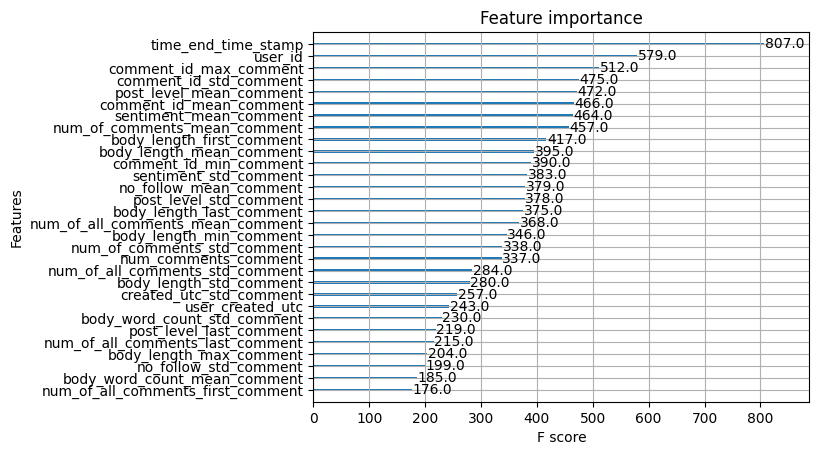

In [25]:
import matplotlib.pyplot as plt
xgb.plot_importance(model, max_num_features=30)

In [98]:
# # polt tree
# xgb.plot_tree(model, num_trees=0, rankdir='LR')
# # save figure in pdf
# fig = plt.gcf()
# # fig.set_size_inches(15000, 1000)
# fig.savefig('tree.pdf')

img = xgb.to_graphviz(model, num_trees=model.best_iteration)
# change size
img.graph_attr = {'size': '20000,10000'}
# save figure in pdf
img.format = 'pdf'
img.render('tree')

'tree.pdf'

In [26]:
# train by only these 30 features
# model.get_score()
features_importance = model.get_score()
features_importance = sorted(features_importance.items(), key=lambda x: x[1], reverse=True)
# if key starts with no_follow or comment_id, then remove it
features_importance = [feature for feature in features_importance if not feature[0].startswith("no_follow") and not feature[0].startswith("comment_id")]
features_importance = [feature[0] for feature in features_importance]
features_importance = features_importance[:30]

# Construct DMatrix
dtrain = xgb.DMatrix(train_user_feature_dataset_total[features_importance], label=train_user_feature_dataset_total['label'])
dvalid = xgb.DMatrix(valid_user_feature_dataset_total[features_importance], label=valid_user_feature_dataset_total['label'])
dtest = xgb.DMatrix(test_user_feature_dataset_total[features_importance], label=test_user_feature_dataset_total['label'])


# Train XGBoost model
model = xgb.train(
    {
    'objective': 'reg:squarederror',
    'max_depth': 10,
    'eta': 0.1,
    'seed': random_seed,  
    }, 
    dtrain,
    num_boost_round=1000,
    evals=[(dvalid, 'valid')],
    early_stopping_rounds=10
)

# Predict
y_pred = model.predict(dtest)
y_test = test_user_feature_dataset_total['label'].values

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("RMSE: %f" % (rmse))

from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
print(classification_report(y_test, y_pred > 0.5))
print("ROC AUC: %f" % (roc_auc_score(y_test, y_pred)))
print("Average precision: %f" % (average_precision_score(y_test, y_pred)))


[0]	valid-rmse:0.49542


[1]	valid-rmse:0.49208
[2]	valid-rmse:0.48890
[3]	valid-rmse:0.48655
[4]	valid-rmse:0.48475
[5]	valid-rmse:0.48340
[6]	valid-rmse:0.48256
[7]	valid-rmse:0.48197
[8]	valid-rmse:0.48096
[9]	valid-rmse:0.48028
[10]	valid-rmse:0.48004
[11]	valid-rmse:0.47966
[12]	valid-rmse:0.47975
[13]	valid-rmse:0.47973
[14]	valid-rmse:0.47975
[15]	valid-rmse:0.48009
[16]	valid-rmse:0.48003
[17]	valid-rmse:0.48004
[18]	valid-rmse:0.48016
[19]	valid-rmse:0.48003
[20]	valid-rmse:0.48041
RMSE: 0.468180
              precision    recall  f1-score   support

           0       0.79      0.67      0.73      3128
           1       0.45      0.60      0.51      1382

    accuracy                           0.65      4510
   macro avg       0.62      0.64      0.62      4510
weighted avg       0.69      0.65      0.66      4510

ROC AUC: 0.691871
Average precision: 0.511974


In [27]:
print(features_importance)

['time_end_time_stamp', 'user_id', 'post_level_mean_comment', 'sentiment_mean_comment', 'num_of_comments_mean_comment', 'body_length_first_comment', 'body_length_mean_comment', 'sentiment_std_comment', 'post_level_std_comment', 'body_length_last_comment', 'num_of_all_comments_mean_comment', 'body_length_min_comment', 'num_of_comments_std_comment', 'num_comments_comment', 'num_of_all_comments_std_comment', 'body_length_std_comment', 'created_utc_std_comment', 'user_created_utc', 'body_word_count_std_comment', 'post_level_last_comment', 'num_of_all_comments_last_comment', 'body_length_max_comment', 'body_word_count_mean_comment', 'num_of_all_comments_first_comment', 'body_word_count_first_comment', 'body_word_count_last_comment', 'edited_mean_comment', 'collapsed_mean_comment', 'post_level_first_comment', 'num_of_all_comments_max_comment']


In [34]:
# save features importance
import pickle
with open("features_importance.pkl", "wb") as f:
    pickle.dump(features_importance, f)

# load features importance

In [21]:
# load features importance
import pickle
with open("features_importance.pkl", "rb") as f:
    features_importance = pickle.load(f)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

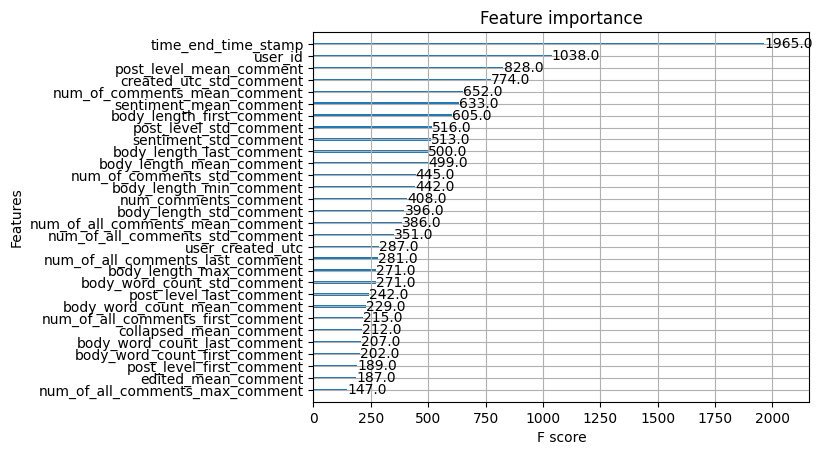

In [29]:

import matplotlib.pyplot as plt
xgb.plot_importance(model, max_num_features=30)
 

In [31]:
img = xgb.to_graphviz(model, num_trees=model.best_iteration)
# change size
img.graph_attr = {'size': '200000,100000'}
# save figure in pdf
img.format = 'pdf'
img.render('tree')

'tree.pdf'

In [104]:
# train by only these 30 features
# model.get_score()
features_importance = model.get_score()
features_importance = sorted(features_importance.items(), key=lambda x: x[1], reverse=True)

features_importance = [feature[0] for feature in features_importance]
features_importance = features_importance[:10]

# Construct DMatrix
dtrain = xgb.DMatrix(train_user_feature_dataset_total[features_importance], label=train_user_feature_dataset_total['label'])
dvalid = xgb.DMatrix(valid_user_feature_dataset_total[features_importance], label=valid_user_feature_dataset_total['label'])
dtest = xgb.DMatrix(test_user_feature_dataset_total[features_importance], label=test_user_feature_dataset_total['label'])


# Train XGBoost model
model = xgb.train(
    {
    'objective': 'binary:logistic',
    'max_depth': 10,
    'eta': 0.1,
    'seed': random_seed,  
    }, 
    dtrain,
    num_boost_round=1000,
    evals=[(dvalid, 'valid')],
    early_stopping_rounds=10
)

# Predict
y_pred = model.predict(data=dtest)
y_test = test_user_feature_dataset_total['label'].values

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("RMSE: %f" % (rmse))

from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
print(classification_report(y_test, y_pred > 0.5))
print("ROC AUC: %f" % (roc_auc_score(y_test, y_pred)))
print("Average precision: %f" % (average_precision_score(y_test, y_pred)))


[0]	valid-logloss:0.68836
[1]	valid-logloss:0.68530
[2]	valid-logloss:0.68571
[3]	valid-logloss:0.68594
[4]	valid-logloss:0.68849
[5]	valid-logloss:0.68760
[6]	valid-logloss:0.69011
[7]	valid-logloss:0.69064
[8]	valid-logloss:0.69136
[9]	valid-logloss:0.69333
[10]	valid-logloss:0.69484
RMSE: 0.514418
              precision    recall  f1-score   support

           0       0.85      0.35      0.50      3128
           1       0.37      0.86      0.52      1382

    accuracy                           0.51      4510
   macro avg       0.61      0.61      0.51      4510
weighted avg       0.70      0.51      0.50      4510

ROC AUC: 0.641306
Average precision: 0.388773


In [ ]:

import matplotlib.pyplot as plt
xgb.plot_importance(model, max_num_features=30)
 

In [72]:
# test MLP from sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

clf = MLPClassifier(random_state=random_seed, max_iter=300).fit(train_user_feature_dataset_total[features_importance], train_user_feature_dataset_total['label'])
y_pred = clf.predict_proba(test_user_feature_dataset_total[features_importance])[:, 1]
y_test = test_user_feature_dataset_total['label'].values
print(classification_report(y_test, y_pred > 0.5))
print("ROC AUC: %f" % (roc_auc_score(y_test, y_pred)))
print("Average precision: %f" % (average_precision_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.69      0.44      0.54      3128
           1       0.30      0.54      0.39      1382

    accuracy                           0.47      4510
   macro avg       0.49      0.49      0.46      4510
weighted avg       0.57      0.47      0.49      4510

ROC AUC: 0.492094
Average precision: 0.303136


# optional: label the party

In [16]:
submission_pool = set()
comment_pool = set()
for i in range(len(graph_generator.time_tuples)):
    time_tuple = graph_generator.time_tuples[i]
    graph_info = graph_generator.graphs_info[time_tuple][graph_generator.graph_type]
    submission_pool |= graph_info.used_submissions
    comment_pool |= graph_info.used_comments
    
user_ids = list(graph_generator.used_redditors)
single_party = []
counter_party = []
ps = {'PS5'}
xbox = {'XboxSeriesX', 'XboxSeriesS'}
user_party = {}  # 0: PS, 1: Xbox, 0-1: the ratio of Xbox / (PS + Xbox)
for user_id in user_ids:
    activities = graph_generator.data["redditor"][user_id].activity
    party_name = set()
    party_number = [0, 0]
    for activity_time, activity_id, activity_type in activities:
        if activity_time >= time_range[0] and activity_time <= time_range[1]:
            if activity_type == "submission" and activity_id not in submission_pool:
                continue
            elif activity_type == "comment" and activity_id not in comment_pool:
                continue
            
            activity = graph_generator.data[activity_type][activity_id]
            if activity._subreddit.name in ps:
                party_name.add('PS')
                party_number[0] += 1
            elif activity._subreddit.name in xbox:
                party_name.add('Xbox')
                party_number[1] += 1
            else:
                continue
            
    if party_number[0] > 0 and party_number[1] > 0:
        user_party[user_id] = party_number[1] / (party_number[1] + party_number[0])
    elif party_number[0] > 0 and party_number[1] == 0:
        user_party[user_id] = 0
    elif party_number[0] == 0 and party_number[1] > 0:
        user_party[user_id] = 1
            
    if len(party_name) > 1:
        counter_party.append(user_id)
    elif len(party_name) == 1:
        single_party.append(user_id)
        
        
user_party_int = {user_id: int(user_party[user_id] >= 0.5) for user_id in user_party}
train_user_feature_dataset_total_with_party = train_user_feature_dataset_total.copy()
train_user_feature_dataset_total_with_party["party"] = train_user_feature_dataset_total.apply(lambda row: user_party_int[row["user_id"]], axis=1)
valid_user_feature_dataset_total_with_party = valid_user_feature_dataset_total.copy()
valid_user_feature_dataset_total_with_party["party"] = valid_user_feature_dataset_total.apply(lambda row: user_party_int[row["user_id"]], axis=1)
test_user_feature_dataset_total_with_party = test_user_feature_dataset_total.copy()
test_user_feature_dataset_total_with_party["party"] = test_user_feature_dataset_total.apply(lambda row: user_party_int[row["user_id"]], axis=1)


In [21]:
# Construct DMatrix
dtrain = xgb.DMatrix(train_user_feature_dataset_total_with_party.drop(columns=['label']), label=train_user_feature_dataset_total_with_party['label'])
dvalid = xgb.DMatrix(valid_user_feature_dataset_total_with_party.drop(columns=['label']), label=valid_user_feature_dataset_total_with_party['label'])
dtest = xgb.DMatrix(test_user_feature_dataset_total_with_party.drop(columns=['label']), label=test_user_feature_dataset_total_with_party['label'])


# Train XGBoost model

model = xgb.train(
    {
    'objective': 'binary:logistic',
    'max_depth': 10,
    'eta': 0.1,
    'seed': random_seed,  
    }, 
    dtrain,
    num_boost_round=1000,
    evals=[(dvalid, 'valid')],
    early_stopping_rounds=10
)

# Predict
y_pred = model.predict(dtest)
y_test = test_user_feature_dataset_total_with_party['label'].values

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("RMSE: %f" % (rmse))

from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
print(classification_report(y_test, y_pred > 0.5))
print("ROC AUC: %f" % (roc_auc_score(y_test, y_pred)))
print("Average precision: %f" % (average_precision_score(y_test, y_pred)))

NameError: name 'xgb' is not defined

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

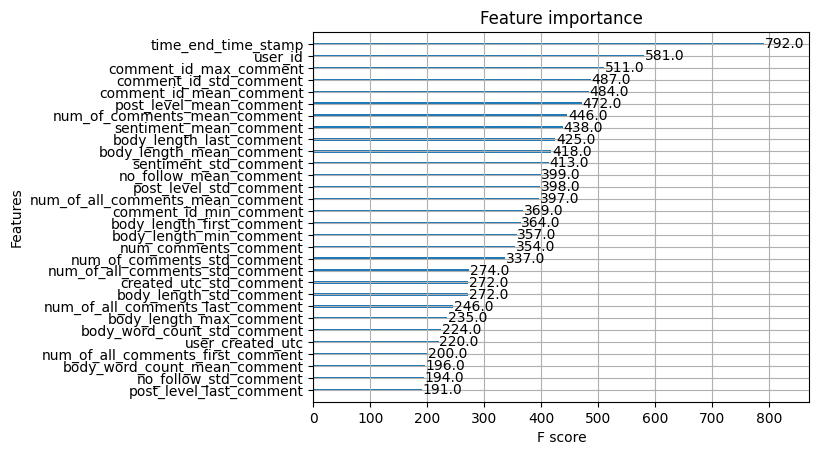

In [96]:
import matplotlib.pyplot as plt
xgb.plot_importance(model, max_num_features=30)

In [156]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Construct DMatrix
features_importance_without_user_id = [feature for feature in features_importance if feature != "user_id"]
# dtrain = xgb.DMatrix(train_user_feature_dataset_total_with_party[features_importance + ["party"]], label=train_user_feature_dataset_total_with_party['label'])
# dvalid = xgb.DMatrix(valid_user_feature_dataset_total_with_party[features_importance + ["party"]], label=valid_user_feature_dataset_total_with_party['label'])
# dtest = xgb.DMatrix(test_user_feature_dataset_total_with_party[features_importance + ["party"]], label=test_user_feature_dataset_total_with_party['label'])
dtrain = xgb.DMatrix(train_user_feature_dataset_total_with_party[features_importance_without_user_id], label=train_user_feature_dataset_total_with_party['label'])
dvalid = xgb.DMatrix(valid_user_feature_dataset_total_with_party[features_importance_without_user_id], label=valid_user_feature_dataset_total_with_party['label'])
dtest = xgb.DMatrix(test_user_feature_dataset_total_with_party[features_importance_without_user_id], label=test_user_feature_dataset_total_with_party['label'])

# Train XGBoost model

model = xgb.train(
    {
    'objective': 'binary:logistic',
    'max_depth': 10,
    'eta': 0.1,
    'seed': random_seed,  
    }, 
    dtrain,
    num_boost_round=1000,
    evals=[(dvalid, 'valid')],
    early_stopping_rounds=10
)

# Predict
y_pred = model.predict(dtest)
y_test = test_user_feature_dataset_total_with_party['label'].values

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("RMSE: %f" % (rmse))

from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
print(classification_report(y_test, y_pred > 0.5))
print("ROC AUC: %f" % (roc_auc_score(y_test, y_pred)))
print("Average precision: %f" % (average_precision_score(y_test, y_pred)))

[0]	valid-logloss:0.68363


[1]	valid-logloss:0.67723
[2]	valid-logloss:0.67220
[3]	valid-logloss:0.66812
[4]	valid-logloss:0.66387
[5]	valid-logloss:0.66047
[6]	valid-logloss:0.65768
[7]	valid-logloss:0.65638
[8]	valid-logloss:0.65435
[9]	valid-logloss:0.65316
[10]	valid-logloss:0.65197
[11]	valid-logloss:0.65080
[12]	valid-logloss:0.65052
[13]	valid-logloss:0.65000
[14]	valid-logloss:0.64934
[15]	valid-logloss:0.64950
[16]	valid-logloss:0.64952
[17]	valid-logloss:0.64984
[18]	valid-logloss:0.64954
[19]	valid-logloss:0.64981
[20]	valid-logloss:0.65011
[21]	valid-logloss:0.65045
[22]	valid-logloss:0.65017
[23]	valid-logloss:0.65027
RMSE: 0.462071
              precision    recall  f1-score   support

           0       0.80      0.69      0.74      3128
           1       0.46      0.60      0.52      1382

    accuracy                           0.66      4510
   macro avg       0.63      0.65      0.63      4510
weighted avg       0.69      0.66      0.67      4510

ROC AUC: 0.704901
Average precision: 0.532864


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

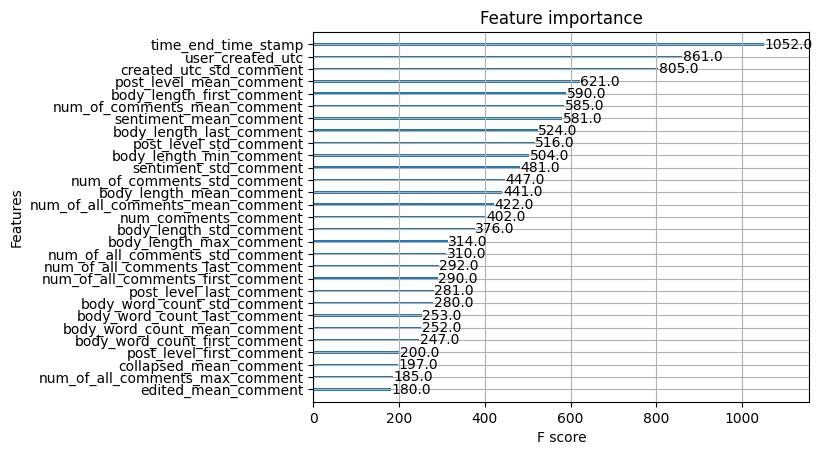

In [157]:
import matplotlib.pyplot as plt
xgb.plot_importance(model, max_num_features=30)

# GCN

In [32]:
# GCN model
import torch
import torch.nn as nn
import torch.nn.functional as F


def graph_convolution(adj, x, w):
    """
    A: adjacency matrix
    X: feature matrix
    W: weight matrix
    """
    # A: (N, N), X: (N, F), W: (F, F')
    # (N, F) * (F, F') = (N, F')
    # (N, N) * (N, F') = (N, F')
    # (N, F') * (F', F) = (N, F)
    return torch.matmul(torch.matmul(adj, x), w)


class GCNLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        F: input feature dimension
        F_: output feature dimension
        """
        super(GCNLayer, self).__init__()
        self.F = input_dim
        self.F_ = output_dim
        self.W = nn.Parameter(torch.FloatTensor(self.F, self.F_))

        nn.init.xavier_uniform_(self.W)

    def forward(self, adj, x):
        return graph_convolution(adj, x, self.W)


class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        """
        A: adjacency matrix
        X: feature matrix
        F: input feature dimension
        F_: output feature dimension
        n_layers: number of GCN layers
        """
        super(GCN, self).__init__()
        self.F = input_dim
        self.F_ = hidden_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.layers = nn.ModuleList()
        for i in range(n_layers):
            self.layers.append(GCNLayer(input_dim, hidden_dim))
            input_dim = hidden_dim
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.drop_out = nn.Dropout(0.5)

    def forward(self, adj, x):
        for i in range(self.n_layers):
            x = self.layers[i](adj, x)
            # add relu and dropout
            # x = F.relu(x)
            # x = self.drop_out(x)
            
        x = self.output_layer(x)
        x = F.softmax(x, dim=1)
        return x


In [33]:
from typing import Dict, List, Tuple
from utils import sp2torch_single


def get_adjacency_matrix_user_embedding_with_batch(time_tuple_used, graph_generator, user_features, train_size, label_size):
    def construct_train_size_graph(time_tuple_used, graph_generator, time_tuple, train_size, label_size):
        graph_constructor_args = {
            "time_tuples": [],
            "n_args": {},
        }
        for idx in range(len(time_tuple_used) - train_size - label_size + 1):
            user_ids_used = set()
            for time_tuple in time_tuple_used[idx:idx + train_size]:
                user_ids_used |= graph_generator.graphs_info[time_tuple][
                    graph_generator.graph_type].used_redditors


            kargs = {
                "used_redditors": user_ids_used,
                "considered_redditors": user_ids_used,
                "time_tuple": (time_tuple_used[idx][0],
                               time_tuple_used[idx + train_size - 1][1]),
            }
            graph_constructor_args["time_tuples"].append(
                kargs["time_tuple"])
            graph_constructor_args["n_args"][kargs["time_tuple"]] = kargs
        graphs, graphs_info = graph_generator.construct_graph_outer(
            **graph_constructor_args)
        return graphs, graphs_info
    
    graphs_created, graphs_info_created = construct_train_size_graph(time_tuple_used, graph_generator, time_tuple_used, train_size, label_size)
    output_tensors = []
    for item in range(len(time_tuple_used) - train_size - label_size + 1):
        time_tuple_temp = time_tuple_used[item]        

        user_ids_used_dict = graphs_info_created[item].used_redditors_index
        idx2user_id = {idx: user_id for user_id, idx in
                       user_ids_used_dict.items()}
        user_ids_used = set(idx2user_id.values())
        user_ids_used_list = [idx2user_id[idx] for idx in
                              range(len(idx2user_id))]
        
        graph = graphs_created[item]
        graph = sp2torch_single(graph).float()
        
        labels = []
        for user_id in user_ids_used_list:
            for i in range(label_size):
                graph_info = graph_generator.graphs_info[time_tuple_used[item + train_size + i]][graph_generator.graph_type]
                if user_id in graph_info.considered_redditors:
                    labels.append(1)
                    break
            else:
                labels.append(0)
        labels = torch.tensor(labels).long()
        
        # collect user features from dataframe (user_features)
        # when user_id and time_end_time_stamp match
        # it should finally be a numpy array before converting to torch tensor
        # so it should follow the order of user_ids_used_list
        user_features_used = []
        for user_id in user_ids_used_list:
            if time_tuple_used[item + train_size - 1][1] not in user_features[(user_features["user_id"] == user_id)]["time_end_time_stamp"].values:
                print(user_id)
                print(user_features[(user_features["user_id"] == user_id)]["time_end_time_stamp"].values)
                print(time_tuple_used[item + train_size - 1][1])
                print("error")
                raise
            user_feature = user_features[(user_features["user_id"] == user_id) & (user_features["time_end_time_stamp"] == time_tuple_used[item + train_size - 1][1])].values
            user_features_used.append(user_feature)
        user_features_used = np.concatenate(user_features_used, axis=0)
        user_features_used = torch.tensor(user_features_used).float()
        
        output_tensors.append((graph, user_features_used, labels))
    return output_tensors        
    
    
    

## if processing user_id and time_end_time_stamp


In [37]:
time_end_time_stamp_min = min(train_user_feature_dataset_total['time_end_time_stamp'])
# transfer time_end_time_stamp_min to year, month, day, hour, minute, second
import datetime
time_end_time_stamp_min = datetime.datetime.fromtimestamp(time_end_time_stamp_min)
print(time_end_time_stamp_min)

2022-01-09 00:00:00


In [ ]:
### embedding

In [148]:
user_embedding_length = 10
user_embedding = nn.Embedding(2000, user_embedding_length).cuda()

In [128]:
## if processing user_id and time_end_time_stamp
from typing import Dict, List, Tuple
from utils import sp2torch_single

user_embedding_length = 1
user_id_to_embedding_idx = {}
user_embedding = nn.Embedding(2000, user_embedding_length).cuda()
time_stamp_adjust = 1 * 24 * 60 * 60
time_end_time_stamp_min = min(train_user_feature_dataset_total['time_end_time_stamp'])

def get_adjacency_matrix_user_embedding_with_batch_optim(time_tuple_used, graph_generator, user_features, train_size, label_size):
    def construct_train_size_graph(time_tuple_used, graph_generator, time_tuple, train_size, label_size):
        graph_constructor_args = {
            "time_tuples": [],
            "n_args": {},
        }
        for idx in range(len(time_tuple_used) - train_size - label_size + 1):
            user_ids_used = set()
            for time_tuple in time_tuple_used[idx:idx + train_size]:
                user_ids_used |= graph_generator.graphs_info[time_tuple][
                    graph_generator.graph_type].used_redditors


            kargs = {
                "used_redditors": user_ids_used,
                "considered_redditors": user_ids_used,
                "time_tuple": (time_tuple_used[idx][0],
                               time_tuple_used[idx + train_size - 1][1]),
            }
            graph_constructor_args["time_tuples"].append(
                kargs["time_tuple"])
            graph_constructor_args["n_args"][kargs["time_tuple"]] = kargs
        graphs, graphs_info = graph_generator.construct_graph_outer(
            **graph_constructor_args)
        return graphs, graphs_info
    user_columns = list(user_features.columns)
    time_end_time_stamp_idx = user_columns.index("time_end_time_stamp")
    user_columns = [column for column in user_columns if column != "user_id" and column != "time_end_time_stamp"]
    # user_columns = [column for column in user_columns if column != "time_end_time_stamp" and column != "time_end_time_stamp_optim"]
    user_columns = user_columns[:time_end_time_stamp_idx] + ["time_end_time_stamp_optim"] + user_columns[time_end_time_stamp_idx:]
    print(user_columns)
    user_features['time_end_time_stamp_optim'] = (user_features['time_end_time_stamp'] - time_end_time_stamp_min) / time_stamp_adjust
    # user_features['time_end_time_stamp_optim'] = user_features['time_end_time_stamp']
    graphs_created, graphs_info_created = construct_train_size_graph(time_tuple_used, graph_generator, time_tuple_used, train_size, label_size)
    output_tensors = []
    for item in range(len(time_tuple_used) - train_size - label_size + 1):
        time_tuple_temp = time_tuple_used[item]        

        user_ids_used_dict = graphs_info_created[item].used_redditors_index
        idx2user_id = {idx: user_id for user_id, idx in
                       user_ids_used_dict.items()}
        user_ids_used = set(idx2user_id.values())
        user_ids_used_list = [idx2user_id[idx] for idx in
                              range(len(idx2user_id))]
        
        graph = graphs_created[item]
        print(graph.nnz)
        graph = sp2torch_single(graph).float()
        
        labels = []
        for user_id in user_ids_used_list:
            for i in range(label_size):
                graph_info = graph_generator.graphs_info[time_tuple_used[item + train_size + i]][graph_generator.graph_type]
                if user_id in graph_info.considered_redditors:
                    labels.append(1)
                    break
            else:
                labels.append(0)
        labels = torch.tensor(labels).long()
        
        # collect user features from dataframe (user_features)
        # when user_id and time_end_time_stamp match
        # it should finally be a numpy array before converting to torch tensor
        # so it should follow the order of user_ids_used_list
        user_features_used = []
        for user_id in user_ids_used_list:
            if time_tuple_used[item + train_size - 1][1] not in user_features[(user_features["user_id"] == user_id)]["time_end_time_stamp"].values:
                print(user_id)
                print(user_features[(user_features["user_id"] == user_id)]["time_end_time_stamp"].values)
                print(time_tuple_used[item + train_size - 1][1])
                print("error")
                raise
            user_feature = user_features[(user_features["user_id"] == user_id) & (user_features["time_end_time_stamp"] == time_tuple_used[item + train_size - 1][1])]
            if user_id not in user_id_to_embedding_idx:
                user_id_to_embedding_idx[user_id] = len(user_id_to_embedding_idx)
            # user_feature = user_feature.drop(columns=["user_id", "time_end_time_stamp"]).values
            user_feature = user_feature[user_columns].values
            # add time_end_time_stamp_optim to user_feature
            user_features_used.append(user_feature)
        user_features_used = np.concatenate(user_features_used, axis=0)
        user_features_used = torch.tensor(user_features_used).float()
        
        output_tensors.append((graph, user_features_used, labels, user_ids_used_list))
    return output_tensors        

In [71]:
print(train_features_used['time_end_time_stamp_optim'])
print(train_features_used['time_end_time_stamp_optim'])

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
41410    26.0
41411    26.0
41412    26.0
41413    26.0
41414    26.0
Name: time_end_time_stamp_optim, Length: 41415, dtype: float64
0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
41410    26.0
41411    26.0
41412    26.0
41413    26.0
41414    26.0
Name: time_end_time_stamp_optim, Length: 41415, dtype: float64


In [129]:


train_features_used = train_user_feature_dataset_total[features_importance]
valid_features_used = valid_user_feature_dataset_total[features_importance]
test_features_used = test_user_feature_dataset_total[features_importance]


test_datasets = get_adjacency_matrix_user_embedding_with_batch_optim(test_time_tuple, graph_generator, test_features_used, train_size, label_size)
train_datasets = get_adjacency_matrix_user_embedding_with_batch_optim(train_time_tuple, graph_generator, train_features_used, train_size, label_size)
valid_datasets = get_adjacency_matrix_user_embedding_with_batch_optim(valid_time_tuple, graph_generator, valid_features_used, train_size, label_size)



/tmp/ipykernel_3719239/3430034.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_features['time_end_time_stamp_optim'] = (user_features['time_end_time_stamp'] - time_end_time_stamp_min) / time_stamp_adjust


['time_end_time_stamp_optim', 'post_level_mean_comment', 'sentiment_mean_comment', 'num_of_comments_mean_comment', 'body_length_first_comment', 'body_length_mean_comment', 'sentiment_std_comment', 'post_level_std_comment', 'body_length_last_comment', 'num_of_all_comments_mean_comment', 'body_length_min_comment', 'num_of_comments_std_comment', 'num_comments_comment', 'num_of_all_comments_std_comment', 'body_length_std_comment', 'created_utc_std_comment', 'user_created_utc', 'body_word_count_std_comment', 'post_level_last_comment', 'num_of_all_comments_last_comment', 'body_length_max_comment', 'body_word_count_mean_comment', 'num_of_all_comments_first_comment', 'body_word_count_first_comment', 'body_word_count_last_comment', 'edited_mean_comment', 'collapsed_mean_comment', 'post_level_first_comment', 'num_of_all_comments_max_comment']


Constructing graph: 100%|██████████| 3/3 [00:05<00:00,  1.98s/it]
/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


9912
10077


/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


9668


/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()
/tmp/ipykernel_3719239/3430034.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_features['time_end_time_stamp_optim'] = (user_features['time_end_time_stamp'] - time_end_time_stamp_min) / time_stamp_adjust


['time_end_time_stamp_optim', 'post_level_mean_comment', 'sentiment_mean_comment', 'num_of_comments_mean_comment', 'body_length_first_comment', 'body_length_mean_comment', 'sentiment_std_comment', 'post_level_std_comment', 'body_length_last_comment', 'num_of_all_comments_mean_comment', 'body_length_min_comment', 'num_of_comments_std_comment', 'num_comments_comment', 'num_of_all_comments_std_comment', 'body_length_std_comment', 'created_utc_std_comment', 'user_created_utc', 'body_word_count_std_comment', 'post_level_last_comment', 'num_of_all_comments_last_comment', 'body_length_max_comment', 'body_word_count_mean_comment', 'num_of_all_comments_first_comment', 'body_word_count_first_comment', 'body_word_count_last_comment', 'edited_mean_comment', 'collapsed_mean_comment', 'post_level_first_comment', 'num_of_all_comments_max_comment']


Constructing graph: 100%|██████████| 27/27 [00:51<00:00,  1.89s/it]
/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


7092
7602


/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


7795


/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


7936


/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


7932


/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


7357


/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


6871


/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


6622


/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


6390


/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


6347


/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


8369


/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


11952


/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


14174


/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


16004


/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


16305


/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


16489


/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


17228


/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


15878


/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


13055


/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


11619


/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


10272


/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


10163


/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


10071


/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


9457


/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


11782


/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


12238


/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


12960


/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()
/tmp/ipykernel_3719239/3430034.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_features['time_end_time_stamp_optim'] = (user_features['time_end_time_stamp'] - time_end_time_stamp_min) / time_stamp_adjust


['time_end_time_stamp_optim', 'post_level_mean_comment', 'sentiment_mean_comment', 'num_of_comments_mean_comment', 'body_length_first_comment', 'body_length_mean_comment', 'sentiment_std_comment', 'post_level_std_comment', 'body_length_last_comment', 'num_of_all_comments_mean_comment', 'body_length_min_comment', 'num_of_comments_std_comment', 'num_comments_comment', 'num_of_all_comments_std_comment', 'body_length_std_comment', 'created_utc_std_comment', 'user_created_utc', 'body_word_count_std_comment', 'post_level_last_comment', 'num_of_all_comments_last_comment', 'body_length_max_comment', 'body_word_count_mean_comment', 'num_of_all_comments_first_comment', 'body_word_count_first_comment', 'body_word_count_last_comment', 'edited_mean_comment', 'collapsed_mean_comment', 'post_level_first_comment', 'num_of_all_comments_max_comment']


Constructing graph: 100%|██████████| 3/3 [00:21<00:00,  7.30s/it]
/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


10084
10234


/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


11075


/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


In [127]:
len(features[0])

30

In [152]:
import time
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report


model = GCN(input_dim=29 + user_embedding_length, hidden_dim=30, output_dim=2, n_layers=1)
user_embedding = nn.Embedding(2000, user_embedding_length).cuda()
model = model.cuda()    
# optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
# including user_embedding which use a different learning rate
optimizer = torch.optim.Adam([{'params': model.parameters(), 'lr': 0.005}, {'params': user_embedding.parameters(), 'lr': 0.005 / user_embedding_length}])
                              
criterion = torch.nn.CrossEntropyLoss()

minimum_loss = 100000000
early_stop = 0
early_stop_threshold = 10
epochs = 300
# features_importance_without_user_id_and_time_end_time_stamp = [feature for feature in features_importance if feature not in ["user_id", "time_end_time_stamp"]]
# features_importance_without_user_id_and_time_end_time_stamp = [feature for feature in features_importance if feature not in ["time_end_time_stamp"]]
# features_importance_without_user_id_and_time_end_time_stamp.append("time_end_time_stamp_optim")
features_importance_without_user_id_and_time_end_time_stamp = [feature for feature in features_importance if feature not in ["user_id"]]
print(features_importance_without_user_id_and_time_end_time_stamp)
features_importance_without_user_id_and_time_end_time_stamp[features_importance_without_user_id_and_time_end_time_stamp.index("time_end_time_stamp")] = "time_end_time_stamp_optim"
max_features = np.max(train_features_used[features_importance_without_user_id_and_time_end_time_stamp].values, axis=0)

max_features = torch.tensor(max_features).float().cuda()
for epoch in range(epochs):
    begin_time = time.time()
    
    for batch_idx, (adj, features, labels, user_ids) in enumerate(train_datasets):
        adj = adj.cuda()
        features = features.cuda()
        features = features / max_features
        user_embedding_temp = user_embedding(torch.LongTensor([user_id_to_embedding_idx[user_id] for user_id in user_ids]).cuda())
        # user_embedding_temp = torch.FloatTensor([[user_id_to_embedding_idx[user_id] / 2000] for user_id in user_ids]).cuda()
        features = torch.cat([features, user_embedding_temp], dim=1)
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(adj, features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        total_loss = 0
        total_output = []
        total_label = []
        for batch_idx, (adj, features, labels, user_ids) in enumerate(valid_datasets):
            adj = adj.cuda()
            features = features.cuda()
            features = features / max_features
            user_embedding_temp = user_embedding(torch.LongTensor([user_id_to_embedding_idx[user_id] for user_id in user_ids]).cuda())
            # user_embedding_temp = torch.FloatTensor([[user_id_to_embedding_idx[user_id] / 2000] for user_id in user_ids]).cuda()
            features = torch.cat([features, user_embedding_temp], dim=1)
            labels = labels.cuda()
            outputs = model(adj, features)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * len(labels)
            # print("valid_loss: {}".format(loss.item()))
            total_output.append(outputs.detach().cpu().numpy()[:, 1])
            total_label.append(labels.detach().cpu().numpy())
            
        total_output = np.concatenate(total_output, axis=0)
        total_label = np.concatenate(total_label, axis=0)
        total_loss /= len(total_label)
        print("Vaildation Result in epoch {}".format(epoch))
        print(classification_report(total_label, total_output > 0.5))
        print("ROC AUC: %f" % (roc_auc_score(total_label, total_output)))
        print("Average precision: %f" % (average_precision_score(total_label, total_output)))
            
        print("Epoch: {}, Time: {}, Valid Loss: {}".format(epoch, time.time() - begin_time, total_loss))
            
            
        if total_loss < minimum_loss:
            minimum_loss = total_loss
            early_stop = 0
            
            test_loss = 0
            test_output = []
            test_label = []
            for batch_idx, (adj, features, labels, user_ids) in enumerate(test_datasets):
                adj = adj.cuda()
                features = features.cuda()
                features = features / max_features
                user_embedding_temp = user_embedding(torch.LongTensor([user_id_to_embedding_idx[user_id] for user_id in user_ids]).cuda())
                # user_embedding_temp = torch.FloatTensor([[user_id_to_embedding_idx[user_id] / 2000] for user_id in user_ids]).cuda()
                features = torch.cat([features, user_embedding_temp], dim=1)
                labels = labels.cuda()
                outputs = model(adj, features)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * len(labels)
                # print("test_loss: {}".format(loss.item()))
                test_output.append(outputs.detach().cpu().numpy()[:, 1])
                test_label.append(labels.detach().cpu().numpy())
                
            test_output = np.concatenate(test_output, axis=0)
            test_label = np.concatenate(test_label, axis=0)
            test_loss /= len(test_label)
            print("Test Result in epoch {}".format(epoch))
            print(classification_report(test_label, test_output > 0.5))
            
            print("ROC AUC: %f" % (roc_auc_score(test_label, test_output)))
            print("Average precision: %f" % (average_precision_score(test_label, test_output)))
            
            print("Epoch: {}, Time: {}, Test Loss: {}".format(epoch, time.time() - begin_time, test_loss))
        else:
            early_stop += 1
            

        if early_stop >= early_stop_threshold:
            break

['time_end_time_stamp', 'post_level_mean_comment', 'sentiment_mean_comment', 'num_of_comments_mean_comment', 'body_length_first_comment', 'body_length_mean_comment', 'sentiment_std_comment', 'post_level_std_comment', 'body_length_last_comment', 'num_of_all_comments_mean_comment', 'body_length_min_comment', 'num_of_comments_std_comment', 'num_comments_comment', 'num_of_all_comments_std_comment', 'body_length_std_comment', 'created_utc_std_comment', 'user_created_utc', 'body_word_count_std_comment', 'post_level_last_comment', 'num_of_all_comments_last_comment', 'body_length_max_comment', 'body_word_count_mean_comment', 'num_of_all_comments_first_comment', 'body_word_count_first_comment', 'body_word_count_last_comment', 'edited_mean_comment', 'collapsed_mean_comment', 'post_level_first_comment', 'num_of_all_comments_max_comment']
Vaildation Result in epoch 0
              precision    recall  f1-score   support

           0       0.52      0.84      0.64      2513
           1       0.31

In [70]:
print(train_datasets[0][1].shape)

torch.Size([1352, 30])


<BarContainer object of 39 artists>

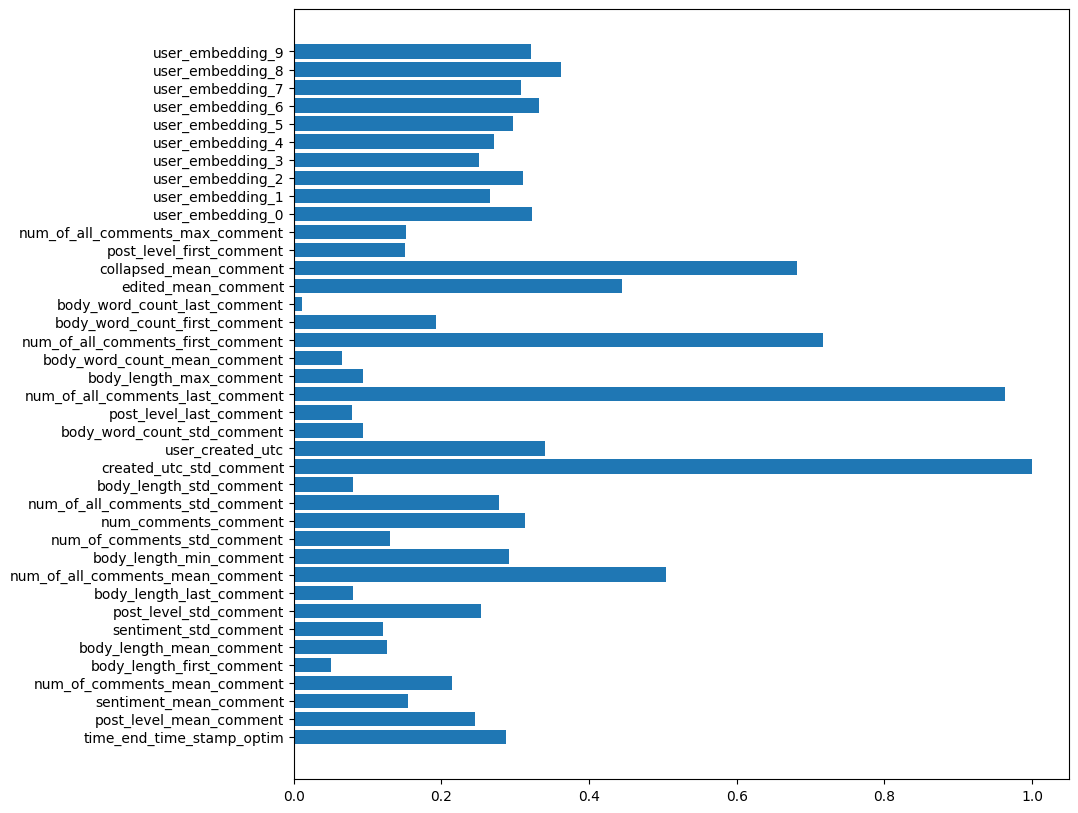

In [153]:
# plot the weight of each feature from combination of parameter GCN layer and MLP layer
gcn_layer = model.layers[0].W.detach().cpu().numpy()
mlp_layer = model.output_layer.weight.detach().cpu().numpy()
feature_weights = gcn_layer.dot(mlp_layer.T)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
feature_names = features_importance_without_user_id_and_time_end_time_stamp + ["user_embedding_{n}".format(n=i) for i in range(user_embedding_length)]

plt.barh(feature_names, (np.abs(feature_weights[:, 0]) + np.abs(feature_weights[:, 1])) / np.max(np.abs(feature_weights[:, 0]) + np.abs(feature_weights[:, 1])))


## GCN original

In [90]:
from typing import Dict, List, Tuple
from utils import sp2torch_single


def get_adjacency_matrix_user_embedding_with_batch(time_tuple_used, graph_generator, user_features, train_size, label_size):
    def construct_train_size_graph(time_tuple_used, graph_generator, time_tuple, train_size, label_size):
        graph_constructor_args = {
            "time_tuples": [],
            "n_args": {},
        }
        for idx in range(len(time_tuple_used) - train_size - label_size + 1):
            user_ids_used = set()
            for time_tuple in time_tuple_used[idx:idx + train_size]:
                user_ids_used |= graph_generator.graphs_info[time_tuple][
                    graph_generator.graph_type].used_redditors


            kargs = {
                "used_redditors": user_ids_used,
                "considered_redditors": user_ids_used,
                "time_tuple": (time_tuple_used[idx][0],
                               time_tuple_used[idx + train_size - 1][1]),
            }
            graph_constructor_args["time_tuples"].append(
                kargs["time_tuple"])
            graph_constructor_args["n_args"][kargs["time_tuple"]] = kargs
        graphs, graphs_info = graph_generator.construct_graph_outer(
            **graph_constructor_args)
        return graphs, graphs_info
    
    graphs_created, graphs_info_created = construct_train_size_graph(time_tuple_used, graph_generator, time_tuple_used, train_size, label_size)
    output_tensors = []
    for item in range(len(time_tuple_used) - train_size - label_size + 1):
        time_tuple_temp = time_tuple_used[item]        

        user_ids_used_dict = graphs_info_created[item].used_redditors_index
        idx2user_id = {idx: user_id for user_id, idx in
                       user_ids_used_dict.items()}
        user_ids_used = set(idx2user_id.values())
        user_ids_used_list = [idx2user_id[idx] for idx in
                              range(len(idx2user_id))]
        
        graph = graphs_created[item]
        print(graph.nnz)
        graph = sp2torch_single(graph).float()
        
        labels = []
        for user_id in user_ids_used_list:
            for i in range(label_size):
                graph_info = graph_generator.graphs_info[time_tuple_used[item + train_size + i]][graph_generator.graph_type]
                if user_id in graph_info.considered_redditors:
                    labels.append(1)
                    break
            else:
                labels.append(0)
        labels = torch.tensor(labels).long()
        
        # collect user features from dataframe (user_features)
        # when user_id and time_end_time_stamp match
        # it should finally be a numpy array before converting to torch tensor
        # so it should follow the order of user_ids_used_list
        user_features_used = []
        for user_id in user_ids_used_list:
            if time_tuple_used[item + train_size - 1][1] not in user_features[(user_features["user_id"] == user_id)]["time_end_time_stamp"].values:
                print(user_id)
                print(user_features[(user_features["user_id"] == user_id)]["time_end_time_stamp"].values)
                print(time_tuple_used[item + train_size - 1][1])
                print("error")
                raise
            user_feature = user_features[(user_features["user_id"] == user_id) & (user_features["time_end_time_stamp"] == time_tuple_used[item + train_size - 1][1])].values
            user_features_used.append(user_feature)
        user_features_used = np.concatenate(user_features_used, axis=0)
        user_features_used = torch.tensor(user_features_used).float()
        
        output_tensors.append((graph, user_features_used, labels))
    return output_tensors        
    
    
    

In [158]:
# testing GCN for these 30 features
# features_importance = model.get_score()
# features_importance = sorted(features_importance.items(), key=lambda x: x[1], reverse=True)

# features_importance = [feature[0] for feature in features_importance]
# features_importance = features_importance[:30]

train_features_used = train_user_feature_dataset_total[features_importance_without_user_id]
valid_features_used = valid_user_feature_dataset_total[features_importance_without_user_id]
test_features_used = test_user_feature_dataset_total[features_importance_without_user_id]

test_datasets = get_adjacency_matrix_user_embedding_with_batch(test_time_tuple, graph_generator, test_features_used, train_size, label_size)
train_datasets = get_adjacency_matrix_user_embedding_with_batch(train_time_tuple, graph_generator, train_features_used, train_size, label_size)
valid_datasets = get_adjacency_matrix_user_embedding_with_batch(valid_time_tuple, graph_generator, valid_features_used, train_size, label_size)



Constructing graph:   0%|          | 0/3 [00:00<?, ?it/s]

Constructing graph: 100%|██████████| 3/3 [00:05<00:00,  1.95s/it]

9912



/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


KeyError: 'user_id'

In [86]:
import time
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report


model = GCN(input_dim=30, hidden_dim=30, output_dim=2, n_layers=1)
model = model.cuda()    
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.CrossEntropyLoss()

minimum_loss = 100000000
early_stop = 0
early_stop_threshold = 10
epochs = 300
max_features = np.max(train_user_feature_dataset_total[features_importance].values, axis=0)
max_features = torch.tensor(max_features).float().cuda()
for epoch in range(epochs):
    begin_time = time.time()
    
    for batch_idx, (adj, features, labels) in enumerate(train_datasets):
        adj = adj.cuda()
        features = features.cuda()
        features = features / max_features
        labels = labels.cuda()
        # detect whether there is nan in adj by torch function
        if torch.isnan(adj).any():
            print("nan in adj")
            print(adj)
            break
        # detect whether there is nan in features
        if np.isnan(features.detach().cpu().numpy()).any():
            print("nan in features")
            print(features)
            break
        # detect whether there is nan in labels
        if np.isnan(labels.detach().cpu().numpy()).any():
            print("nan in labels")
            print(labels)
            break
        optimizer.zero_grad()
        outputs = model(adj, features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print("train_loss: {}".format(loss.item()))
        if torch.isnan(loss).any():
            print("nan in loss")
            print(loss)
            break
        if torch.isnan(outputs).any():
            print("nan in outputs")
            print(outputs)
            break
    
    model.eval()
    with torch.no_grad():
        total_loss = 0
        total_output = []
        total_label = []
        for batch_idx, (adj, features, labels) in enumerate(valid_datasets):
            adj = adj.cuda()
            features = features.cuda()
            features = features / max_features
            labels = labels.cuda()
            outputs = model(adj, features)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * len(labels)
            # print("valid_loss: {}".format(loss.item()))
            total_output.append(outputs.detach().cpu().numpy()[:, 1])
            total_label.append(labels.detach().cpu().numpy())
            
        total_output = np.concatenate(total_output, axis=0)
        total_label = np.concatenate(total_label, axis=0)
        total_loss /= len(total_label)
        print("Vaildation Result in epoch {}".format(epoch))
        print(classification_report(total_label, total_output > 0.5))
        # detect whether there is nan in test_output
        if np.isnan(total_output).any():
            print("nan in valid_output")
            print(total_output)
            break
        print("ROC AUC: %f" % (roc_auc_score(total_label, total_output)))
        print("Average precision: %f" % (average_precision_score(total_label, total_output)))
            
        print("Epoch: {}, Time: {}, Valid Loss: {}".format(epoch, time.time() - begin_time, total_loss))
            
            
        if total_loss < minimum_loss:
            minimum_loss = total_loss
            early_stop = 0
            
            test_loss = 0
            test_output = []
            test_label = []
            for batch_idx, (adj, features, labels) in enumerate(test_datasets):
                adj = adj.cuda()
                features = features.cuda()
                features = features / max_features
                labels = labels.cuda()
                outputs = model(adj, features)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * len(labels)
                # print("test_loss: {}".format(loss.item()))
                test_output.append(outputs.detach().cpu().numpy()[:, 1])
                test_label.append(labels.detach().cpu().numpy())
                
            test_output = np.concatenate(test_output, axis=0)
            test_label = np.concatenate(test_label, axis=0)
            test_loss /= len(test_label)
            print("Test Result in epoch {}".format(epoch))
            print(classification_report(test_label, test_output > 0.5))
            
            print("ROC AUC: %f" % (roc_auc_score(test_label, test_output)))
            print("Average precision: %f" % (average_precision_score(test_label, test_output)))
            
            print("Epoch: {}, Time: {}, Test Loss: {}".format(epoch, time.time() - begin_time, test_loss))
        else:
            early_stop += 1
            

        if early_stop >= early_stop_threshold:
            break

Vaildation Result in epoch 0
              precision    recall  f1-score   support

           0       0.54      1.00      0.70      2513
           1       0.00      0.00      0.00      2108

    accuracy                           0.54      4621
   macro avg       0.27      0.50      0.35      4621
weighted avg       0.30      0.54      0.38      4621

ROC AUC: 0.379516
Average precision: 0.378471
Epoch: 0, Time: 0.09859347343444824, Valid Loss: 0.6977845164662031
Test Result in epoch 0
              precision    recall  f1-score   support

           0       0.69      1.00      0.82      3128
           1       0.00      0.00      0.00      1382

    accuracy                           0.69      4510
   macro avg       0.35      0.50      0.41      4510
weighted avg       0.48      0.69      0.57      4510

ROC AUC: 0.359874
Average precision: 0.235758
Epoch: 0, Time: 0.12115049362182617, Test Loss: 0.6757291191565223
Vaildation Result in epoch 1
              precision    recall  f1-

/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

Vaildation Result in epoch 2
              precision    recall  f1-score   support

           0       0.55      1.00      0.71      2513
           1       0.84      0.01      0.02      2108

    accuracy                           0.55      4621
   macro avg       0.69      0.50      0.36      4621
weighted avg       0.68      0.55      0.39      4621

ROC AUC: 0.623863
Average precision: 0.566599
Epoch: 2, Time: 0.09160780906677246, Valid Loss: 0.6863108056109077
Test Result in epoch 2
              precision    recall  f1-score   support

           0       0.69      1.00      0.82      3128
           1       0.50      0.01      0.01      1382

    accuracy                           0.69      4510
   macro avg       0.60      0.50      0.42      4510
weighted avg       0.63      0.69      0.57      4510

ROC AUC: 0.644022
Average precision: 0.421618
Epoch: 2, Time: 0.11292600631713867, Test Loss: 0.6651883655271086
Vaildation Result in epoch 3
              precision    recall  f1-

In [103]:
model.layers[0].W

Parameter containing:
tensor([[-0.2227, -0.1763, -0.3603, -0.0516, -0.0065,  0.0456,  0.1939, -0.2052,
         -0.4094,  0.3658, -0.3455, -0.3483, -0.2115,  0.0906, -0.3581],
        [-0.0416,  0.0864,  0.3683,  0.2296, -0.0031, -0.3758, -0.3201, -0.3234,
         -0.0513, -0.2791,  0.0787,  0.2201,  0.2979,  0.0129,  0.1028],
        [ 0.4959, -0.3227,  0.4974,  0.2184, -0.5280,  0.1943,  0.3394,  0.1334,
          0.0945, -0.5563,  0.3566,  0.0402, -0.2335, -0.0911,  0.3375],
        [-0.5071, -0.0652,  0.1261,  0.0774,  0.0584,  0.0622,  0.1093, -0.0313,
         -0.0929, -0.2100, -0.0503, -0.2105,  0.2649, -0.2119, -0.2043],
        [ 0.1076, -0.2809,  0.0477, -0.0313,  0.0572, -0.0793, -0.1944,  0.0406,
         -0.2067, -0.2829, -0.2765,  0.1613,  0.0406, -0.2509, -0.2436],
        [ 0.0813, -0.1216,  0.1965,  0.1554, -0.2994,  0.0085,  0.4386, -0.0530,
          0.5163, -0.2449, -0.0343,  0.3255,  0.3138,  0.3916,  0.0773],
        [ 0.2730, -0.3302,  0.0031, -0.1106, -0.1745, 

<BarContainer object of 30 artists>

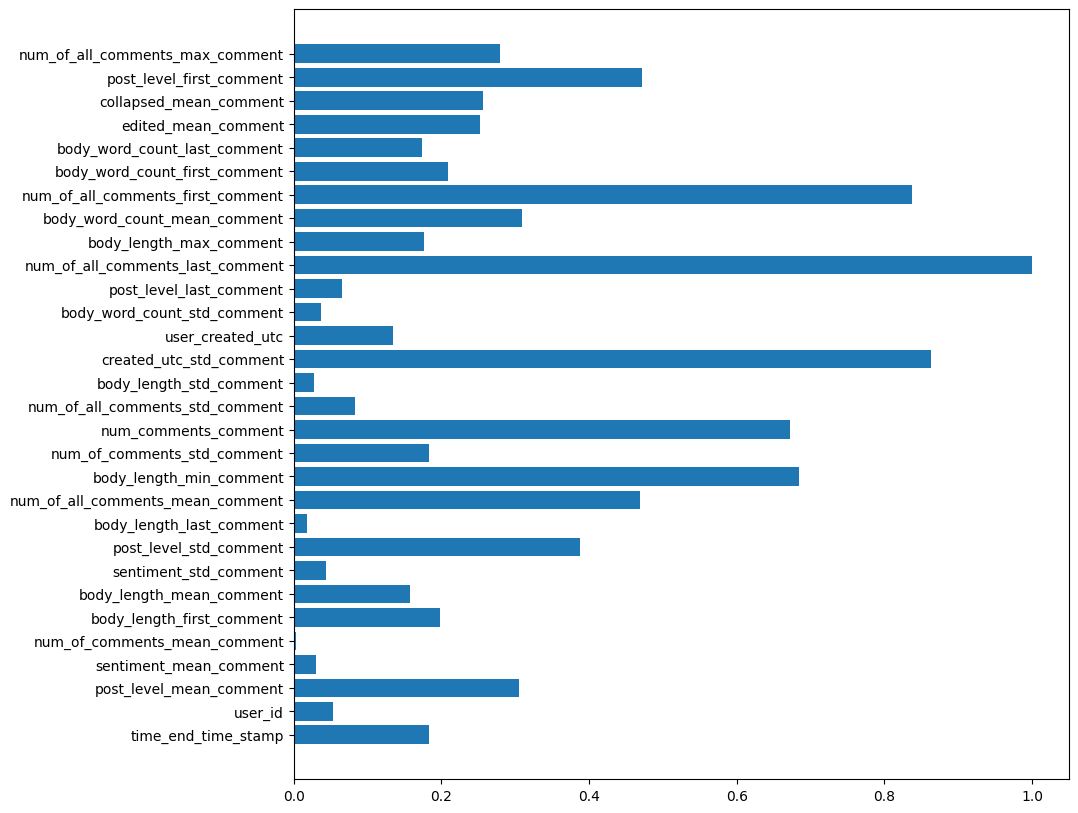

In [112]:
# plot the weight of each feature from combination of parameter GCN layer and MLP layer
gcn_layer = model.layers[0].W.detach().cpu().numpy()
mlp_layer = model.output_layer.weight.detach().cpu().numpy()
feature_weights = gcn_layer.dot(mlp_layer.T)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

# plt.barh(features_importance, (np.abs(feature_weights[:, 0]) + np.abs(feature_weights[:, 1])) / np.max(np.abs(feature_weights[:, 0]) + np.abs(feature_weights[:, 1])))
# sort the features by their importance: from high to low
plt.barh



In [156]:
import torch
import torch.nn as nn
import torch.nn.functional as F


dv = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class GraphAttentionLayer(nn.Module):
    """
    Simple GAT layer, similar to https://arxiv.org/abs/1710.10903
    """

    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GraphAttentionLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.empty(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.empty(size=(2 * out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, h, adj):
        Wh = torch.mm(h, self.W)  # h.shape: (N, in_features), Wh.shape: (N, out_features)
        e = self._prepare_attentional_mechanism_input(Wh)

        zero_vec = -9e15 * torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime = torch.matmul(attention, Wh)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

    def _prepare_attentional_mechanism_input(self, Wh):
        # Wh.shape (N, out_feature)
        # self.a.shape (2 * out_feature, 1)
        # Wh1&2.shape (N, 1)
        # e.shape (N, N)
        Wh1 = torch.matmul(Wh, self.a[:self.out_features, :])
        Wh2 = torch.matmul(Wh, self.a[self.out_features:, :])
        # broadcast add
        e = Wh1 + Wh2.T
        return self.leakyrelu(e)

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'


class SpecialSpmmFunction(torch.autograd.Function):
    """Special function for only sparse region backpropataion layer."""

    @staticmethod
    def forward(ctx, indices, values, shape, b):
        assert indices.requires_grad == False
        a = torch.sparse_coo_tensor(indices, values, shape)
        ctx.save_for_backward(a, b)
        ctx.N = shape[0]
        return torch.matmul(a, b)

    @staticmethod
    def backward(ctx, grad_output):
        a, b = ctx.saved_tensors
        grad_values = grad_b = None
        if ctx.needs_input_grad[1]:
            grad_a_dense = grad_output.matmul(b.t())
            edge_idx = a._indices()[0, :] * ctx.N + a._indices()[1, :]
            grad_values = grad_a_dense.view(-1)[edge_idx]
        if ctx.needs_input_grad[3]:
            grad_b = a.t().matmul(grad_output)
        return None, grad_values, None, grad_b


class SpecialSpmm(nn.Module):
    def forward(self, indices, values, shape, b):
        return SpecialSpmmFunction.apply(indices, values, shape, b)


class SpGraphAttentionLayer(nn.Module):
    """
    Sparse version GAT layer, similar to https://arxiv.org/abs/1710.10903
    """

    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(SpGraphAttentionLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_normal_(self.W.data, gain=1.414)

        self.a = nn.Parameter(torch.zeros(size=(1, 2 * out_features)))
        nn.init.xavier_normal_(self.a.data, gain=1.414)

        self.dropout = nn.Dropout(dropout)
        self.leakyrelu = nn.LeakyReLU(self.alpha)
        self.special_spmm = SpecialSpmm()

    def forward(self, input, adj):
        # dv = 'cuda' if input.is_cuda else 'cpu'

        N = input.size()[0]
        edge = adj.nonzero().t()

        h = torch.mm(input, self.W)
        # h: N x out
        assert not torch.isnan(h).any()

        # Self-attention on the nodes - Shared attention mechanism
        edge_h = torch.cat((h[edge[0, :], :], h[edge[1, :], :]), dim=1).t()
        # edge: 2*D x E

        edge_e = torch.exp(-self.leakyrelu(self.a.mm(edge_h).squeeze()))
        # assert not torch.isnan(edge_e).any()
        # edge_e: E

        e_rowsum = self.special_spmm(edge, edge_e, torch.Size([N, N]), torch.ones(size=(N, 1), device=dv))
        # e_rowsum: N x 1

        edge_e = self.dropout(edge_e)
        # edge_e: E

        h_prime = self.special_spmm(edge, edge_e, torch.Size([N, N]), h)
        # assert not torch.isnan(h_prime).any()
        # h_prime: N x out

        h_prime = h_prime.div(e_rowsum + 1e-16)
        # h_prime: N x out
        assert not torch.isnan(h_prime).any()

        if self.concat:
            # if this layer is not last layer,
            return F.elu(h_prime)
        else:
            # if this layer is last layer,
            return h_prime

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'


class GAT(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, alpha, nheads):
        """Dense version of GAT."""
        super(GAT, self).__init__()
        self.dropout = dropout

        self.attentions = [GraphAttentionLayer(nfeat, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in
                           range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_att = GraphAttentionLayer(nhid * nheads, nclass, dropout=dropout, alpha=alpha, concat=False)

    def forward(self, x, adj):
        x = F.dropout(x, self.dropout, training=self.training)
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_att(x, adj))
        return F.log_softmax(x, dim=1)


class SpGAT(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, alpha, nheads):
        """Sparse version of GAT."""
        super(SpGAT, self).__init__()
        self.dropout = dropout

        self.attentions = [SpGraphAttentionLayer(nfeat,
                                                 nhid,
                                                 dropout=dropout,
                                                 alpha=alpha,
                                                 concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_att = SpGraphAttentionLayer(nhid * nheads,
                                             nclass,
                                             dropout=dropout,
                                             alpha=alpha,
                                             concat=False)

    def forward(self, x, adj):
        x = F.dropout(x, self.dropout, training=self.training)
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        if torch.isnan(x).any():
            print("nan in x")
            print(x)
            # find the nan position in (x1, y1) format
            print(torch.where(torch.isnan(x)))
            print(x[torch.where(torch.isnan(x))[0], :])
            print(x[:, torch.where(torch.isnan(x))[1]])
            
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_att(x, adj))
        return F.log_softmax(x, dim=1)


In [157]:
import time
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report


model = SpGAT(30, 15, 2, dropout=0.1, alpha=0.2, nheads=1)
model = model.cuda()    
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

minimum_loss = 100000000
early_stop = 0
early_stop_threshold = 10
epochs = 300

# get max for the features in each dimension from train in the following code
max_features = np.max(train_user_feature_dataset_total[features_importance].values, axis=0)
max_features = torch.tensor(max_features).float().cuda()

for epoch in range(epochs):
    begin_time = time.time()
    
    for batch_idx, (adj, features, labels) in enumerate(train_datasets):
        adj = adj.cuda().to_dense()
        features = features.cuda()
        # normalize features
        features = features / max_features
        # print(features)
        
        labels = labels.cuda()
        # detect whether there is nan in adj by torch function
        if torch.isnan(adj).any():
            print("nan in adj")
            print(adj)
            break
        # detect whether there is nan in features
        if np.isnan(features.detach().cpu().numpy()).any():
            print("nan in features")
            print(features)
            break
        # detect whether there is nan in labels
        if np.isnan(labels.detach().cpu().numpy()).any():
            print("nan in labels")
            print(labels)
            break
        optimizer.zero_grad()
        outputs = model(features, adj)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        print("train_loss: {}".format(loss.item()))
        if torch.isnan(loss).any():
            print("nan in loss")
            print(loss)
            break
        if torch.isnan(outputs).any():
            print("nan in outputs")
            print(outputs)
            break
    
    model.eval()
    with torch.no_grad():
        total_loss = 0
        total_output = []
        total_label = []
        for batch_idx, (adj, features, labels) in enumerate(valid_datasets):
            adj = adj.cuda().to_dense()
            features = features.cuda()
            features = features / max_features
            labels = labels.cuda()
            outputs = model(features, adj)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * len(labels)
            print("valid_loss: {}".format(loss.item()))
            total_output.append(outputs.detach().cpu().numpy()[:, 1])
            total_label.append(labels.detach().cpu().numpy())
            
        total_output = np.concatenate(total_output, axis=0)
        total_label = np.concatenate(total_label, axis=0)
        total_loss /= len(total_label)
        print("Vaildation Result in epoch {}".format(epoch))
        print(classification_report(total_label, total_output > 0.5))
        # detect whether there is nan in test_output
        if np.isnan(total_output).any():
            print("nan in valid_output")
            print(total_output)
            break
        print("ROC AUC: %f" % (roc_auc_score(total_label, total_output)))
        print("Average precision: %f" % (average_precision_score(total_label, total_output)))
            
        print("Epoch: {}, Time: {}, Valid Loss: {}".format(epoch, time.time() - begin_time, total_loss))
            
            
        if total_loss < minimum_loss:
            minimum_loss = total_loss
            early_stop = 0
            
            test_loss = 0
            test_output = []
            test_label = []
            for batch_idx, (adj, features, labels) in enumerate(test_datasets):
                adj = adj.cuda().to_dense()
                features = features.cuda()
                features = features / max_features
                labels = labels.cuda()
                outputs = model(features, adj)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * len(labels)
                print("test_loss: {}".format(loss.item()))
                test_output.append(outputs.detach().cpu().numpy()[:, 1])
                test_label.append(labels.detach().cpu().numpy())
                
            test_output = np.concatenate(test_output, axis=0)
            test_label = np.concatenate(test_label, axis=0)
            test_loss /= len(test_label)
            print("Test Result in epoch {}".format(epoch))
            print(classification_report(test_label, test_output > 0.5))
            
            print("ROC AUC: %f" % (roc_auc_score(test_label, test_output)))
            print("Average precision: %f" % (average_precision_score(test_label, test_output)))
            
            print("Epoch: {}, Time: {}, Test Loss: {}".format(epoch, time.time() - begin_time, test_loss))
        else:
            early_stop += 1
            

        if early_stop >= early_stop_threshold:
            break

train_loss: 1.098239779472351
train_loss: 1.1099679470062256
train_loss: 1.075100302696228
train_loss: 0.9791007041931152
train_loss: 1.0077424049377441
train_loss: 1.0146901607513428
train_loss: 0.9874982833862305
train_loss: 1.012727975845337
train_loss: 0.9732274413108826
train_loss: 0.7327948808670044
train_loss: 0.660691499710083
train_loss: 0.7127415537834167
train_loss: 0.7293770909309387
train_loss: 0.87617427110672
train_loss: 0.9001114368438721
train_loss: 0.8375851511955261
train_loss: 0.832088828086853
train_loss: 0.7715268731117249
train_loss: 0.7874834537506104
train_loss: 0.7874439358711243
train_loss: 0.824832558631897
train_loss: 0.8679724931716919
train_loss: 0.8423253893852234
train_loss: 0.6822420358657837
train_loss: 0.7315860986709595
train_loss: 0.720087468624115
train_loss: 0.7355231046676636
valid_loss: 0.7725978493690491
valid_loss: 0.726797342300415
valid_loss: 0.7156100273132324
Vaildation Result in epoch 0
              precision    recall  f1-score   suppo

/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

train_loss: 0.6799592971801758
train_loss: 0.6586849093437195
train_loss: 0.6789441108703613
train_loss: 0.6877378821372986
train_loss: 0.7257075905799866
train_loss: 0.7356005311012268
train_loss: 0.7188301682472229
train_loss: 0.7177236080169678
train_loss: 0.7046244144439697
train_loss: 0.7099315524101257
train_loss: 0.7083600759506226
train_loss: 0.7229672074317932
train_loss: 0.730033814907074
train_loss: 0.7251524329185486
train_loss: 0.6806153059005737
train_loss: 0.697175920009613
train_loss: 0.6951237320899963
train_loss: 0.6998243927955627
valid_loss: 0.7059597373008728
valid_loss: 0.6957417726516724
valid_loss: 0.694155216217041
Vaildation Result in epoch 1
              precision    recall  f1-score   support

           0       0.54      1.00      0.70      2513
           1       0.00      0.00      0.00      2108

    accuracy                           0.54      4621
   macro avg       0.27      0.50      0.35      4621
weighted avg       0.30      0.54      0.38      46

/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

              precision    recall  f1-score   support

           0       0.69      1.00      0.82      3128
           1       0.00      0.00      0.00      1382

    accuracy                           0.69      4510
   macro avg       0.35      0.50      0.41      4510
weighted avg       0.48      0.69      0.57      4510

ROC AUC: 0.488461
Average precision: 0.282281
Epoch: 1, Time: 0.3183269500732422, Test Loss: 0.7116441007728322
train_loss: 0.7105370759963989
train_loss: 0.71055668592453
train_loss: 0.708493173122406
train_loss: 0.7019789814949036
train_loss: 0.7028184533119202
train_loss: 0.7018572688102722
train_loss: 0.6988436579704285
train_loss: 0.6991128921508789
train_loss: 0.6968854069709778
train_loss: 0.6918282508850098
train_loss: 0.6938170194625854
train_loss: 0.6958856582641602
train_loss: 0.6963391304016113
train_loss: 0.6834849119186401
train_loss: 0.6790615916252136
train_loss: 0.6839255094528198
train_loss: 0.6841964721679688
train_loss: 0.6892810463905334
train_

/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

train_loss: 0.7153928875923157
train_loss: 0.7363731265068054
train_loss: 0.7248793840408325
train_loss: 0.7187557220458984
train_loss: 0.6626411080360413
train_loss: 0.6460028290748596
train_loss: 0.6684635281562805
train_loss: 0.6698789000511169
train_loss: 0.6890704035758972
train_loss: 0.677467405796051
train_loss: 0.6804279685020447
train_loss: 0.6630313396453857
train_loss: 0.6531009078025818
train_loss: 0.654336154460907
train_loss: 0.7251997590065002
train_loss: 0.6960928440093994
train_loss: 0.7071672677993774
train_loss: 0.6906680464744568
valid_loss: 0.6750624179840088
valid_loss: 0.7001429796218872
valid_loss: 0.7093961834907532
Vaildation Result in epoch 3
              precision    recall  f1-score   support

           0       0.54      1.00      0.70      2513
           1       0.00      0.00      0.00      2108

    accuracy                           0.54      4621
   macro avg       0.27      0.50      0.35      4621
weighted avg       0.30      0.54      0.38      4

/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

train_loss: 0.666469156742096
train_loss: 0.6595498323440552
train_loss: 0.6671334505081177
train_loss: 0.683296799659729
train_loss: 0.6708680987358093
train_loss: 0.6644594073295593
train_loss: 0.6628950834274292
train_loss: 0.6485823392868042
train_loss: 0.6612897515296936
train_loss: 0.7306045889854431
train_loss: 0.7594338655471802
train_loss: 0.7412837147712708
train_loss: 0.7317622303962708
train_loss: 0.6580520868301392
train_loss: 0.636898934841156
train_loss: 0.665784478187561
train_loss: 0.667576789855957
train_loss: 0.6910439729690552
train_loss: 0.67684406042099
train_loss: 0.6801621913909912
train_loss: 0.6593186855316162
train_loss: 0.6480313539505005
train_loss: 0.6501609683036804
train_loss: 0.7302201390266418
train_loss: 0.6974245309829712
train_loss: 0.7090963125228882
train_loss: 0.6911962032318115
valid_loss: 0.674454391002655
valid_loss: 0.7011510133743286
valid_loss: 0.7109237909317017
Vaildation Result in epoch 4
              precision    recall  f1-score   sup

/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

train_loss: 0.7401942610740662
train_loss: 0.73064124584198
train_loss: 0.6583234071731567
train_loss: 0.6376662850379944
train_loss: 0.6659486889839172
train_loss: 0.667731761932373
train_loss: 0.6906075477600098
train_loss: 0.6768251061439514
train_loss: 0.6800786852836609
train_loss: 0.6598892211914062
train_loss: 0.6489163637161255
train_loss: 0.6509822010993958
train_loss: 0.7289207577705383
train_loss: 0.6969261169433594
train_loss: 0.708334743976593
train_loss: 0.6909084320068359
valid_loss: 0.6746542453765869
valid_loss: 0.7006617188453674
valid_loss: 0.7102094888687134
Vaildation Result in epoch 5
              precision    recall  f1-score   support

           0       0.54      1.00      0.70      2513
           1       0.00      0.00      0.00      2108

    accuracy                           0.54      4621
   macro avg       0.27      0.50      0.35      4621
weighted avg       0.30      0.54      0.38      4621

ROC AUC: 0.468422
Average precision: 0.414413
Epoch: 5, Tim

/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

train_loss: 0.6665011048316956
train_loss: 0.6830857396125793
train_loss: 0.6706200838088989
train_loss: 0.6643601059913635
train_loss: 0.6628620624542236
train_loss: 0.6488755941390991
train_loss: 0.6614629030227661
train_loss: 0.729314923286438
train_loss: 0.7570580840110779
train_loss: 0.7391385436058044
train_loss: 0.7297279238700867
train_loss: 0.6585102081298828
train_loss: 0.6381205320358276
train_loss: 0.666016697883606
train_loss: 0.6677786707878113
train_loss: 0.6903866529464722
train_loss: 0.6767878532409668
train_loss: 0.6800060868263245
train_loss: 0.6599855422973633
train_loss: 0.649029016494751
train_loss: 0.6510587930679321
train_loss: 0.7287437319755554
train_loss: 0.6968051791191101
train_loss: 0.7081822752952576
train_loss: 0.6908330917358398
valid_loss: 0.6746364831924438
valid_loss: 0.7005962133407593
valid_loss: 0.7101266384124756
Vaildation Result in epoch 6
              precision    recall  f1-score   support

           0       0.54      1.00      0.70      25

/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

train_loss: 0.6677114963531494
train_loss: 0.6903133988380432
train_loss: 0.6767296195030212
train_loss: 0.6799320578575134
train_loss: 0.6598597764968872
train_loss: 0.6488305926322937
train_loss: 0.6508739590644836
train_loss: 0.7289073467254639
train_loss: 0.696783721446991
train_loss: 0.7081733345985413
train_loss: 0.6908007860183716
valid_loss: 0.6745774745941162
valid_loss: 0.7006083130836487
valid_loss: 0.710159420967102
Vaildation Result in epoch 7
              precision    recall  f1-score   support

           0       0.54      1.00      0.70      2513
           1       0.00      0.00      0.00      2108

    accuracy                           0.54      4621
   macro avg       0.27      0.50      0.35      4621
weighted avg       0.30      0.54      0.38      4621

ROC AUC: 0.469547
Average precision: 0.414903
Epoch: 7, Time: 0.28368496894836426, Valid Loss: 0.6952287603497789
train_loss: 0.6651745438575745
train_loss: 0.6581942439079285
train_loss: 0.6661509275436401
train

/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

train_loss: 0.6610985994338989
train_loss: 0.729574978351593
train_loss: 0.7573744654655457
train_loss: 0.7391868233680725
train_loss: 0.7296268343925476
train_loss: 0.6584186553955078
train_loss: 0.6380051970481873
train_loss: 0.665897011756897
train_loss: 0.6676517128944397
train_loss: 0.6902307271957397
train_loss: 0.6766741275787354
train_loss: 0.6798585653305054
train_loss: 0.6597634553909302
train_loss: 0.6486794352531433
train_loss: 0.6507344841957092
train_loss: 0.729006826877594
train_loss: 0.6967417001724243
train_loss: 0.7081301808357239
train_loss: 0.6907573938369751
valid_loss: 0.6745328307151794
valid_loss: 0.7005949020385742
valid_loss: 0.7101544141769409
Vaildation Result in epoch 8
              precision    recall  f1-score   support

           0       0.54      1.00      0.70      2513
           1       0.00      0.00      0.00      2108

    accuracy                           0.54      4621
   macro avg       0.27      0.50      0.35      4621
weighted avg       0

/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

train_loss: 0.6650047898292542
train_loss: 0.6579990386962891
train_loss: 0.6659737229347229
train_loss: 0.6827887296676636
train_loss: 0.6702243685722351
train_loss: 0.6639833450317383
train_loss: 0.6624060273170471
train_loss: 0.648309051990509
train_loss: 0.6609305739402771
train_loss: 0.7296739220619202
train_loss: 0.7574800252914429
train_loss: 0.7391658425331116
train_loss: 0.7295337915420532
train_loss: 0.6583878397941589
train_loss: 0.6379848718643188
train_loss: 0.6658489108085632
train_loss: 0.6675992608070374
train_loss: 0.6901403665542603
train_loss: 0.6766206622123718
train_loss: 0.6797859072685242
train_loss: 0.6596822738647461
train_loss: 0.648550808429718
train_loss: 0.6506136655807495
train_loss: 0.7290835976600647
train_loss: 0.6966936588287354
train_loss: 0.7080772519111633
train_loss: 0.690711259841919
valid_loss: 0.6744921207427979
valid_loss: 0.7005755305290222
valid_loss: 0.7101393938064575
Vaildation Result in epoch 9
              precision    recall  f1-score 

/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

train_loss: 0.6583582758903503
train_loss: 0.6379668712615967
train_loss: 0.665801465511322
train_loss: 0.6675480604171753
train_loss: 0.6900506019592285
train_loss: 0.6765678524971008
train_loss: 0.679713785648346
train_loss: 0.6596031188964844
train_loss: 0.6484248042106628
train_loss: 0.650495171546936
train_loss: 0.7291585206985474
train_loss: 0.6966458559036255
train_loss: 0.7080246806144714
train_loss: 0.6906648874282837
valid_loss: 0.6744527220726013
valid_loss: 0.7005550265312195
valid_loss: 0.7101234793663025
Vaildation Result in epoch 10
              precision    recall  f1-score   support

           0       0.54      1.00      0.70      2513
           1       0.00      0.00      0.00      2108

    accuracy                           0.54      4621
   macro avg       0.27      0.50      0.35      4621
weighted avg       0.30      0.54      0.38      4621

ROC AUC: 0.471305
Average precision: 0.415746
Epoch: 10, Time: 0.2857975959777832, Valid Loss: 0.6951577097300042
train

/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

train_loss: 0.6637560129165649
train_loss: 0.6621271371841431
train_loss: 0.6479774713516235
train_loss: 0.6606050133705139
train_loss: 0.7298609614372253
train_loss: 0.7576786279678345
train_loss: 0.7391160130500793
train_loss: 0.7293440103530884
train_loss: 0.6583296060562134
train_loss: 0.6379501819610596
train_loss: 0.6657551527023315
train_loss: 0.6674976944923401
train_loss: 0.6899617314338684
train_loss: 0.6765157580375671
train_loss: 0.6796419024467468
train_loss: 0.659525454044342
train_loss: 0.648301899433136
train_loss: 0.6503793001174927
train_loss: 0.7292315363883972
train_loss: 0.6965977549552917
train_loss: 0.70797199010849
train_loss: 0.6906188726425171
valid_loss: 0.6744136810302734
valid_loss: 0.7005336880683899
valid_loss: 0.7101064920425415
Vaildation Result in epoch 11
              precision    recall  f1-score   support

           0       0.54      1.00      0.70      2513
           1       0.00      0.00      0.00      2108

    accuracy                       

/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

train_loss: 0.6795699596405029
train_loss: 0.6594498157501221
train_loss: 0.6481819748878479
train_loss: 0.6502665281295776
train_loss: 0.729302167892456
train_loss: 0.6965493559837341
train_loss: 0.7079192996025085
train_loss: 0.6905725598335266
valid_loss: 0.6743757128715515
valid_loss: 0.7005112767219543
valid_loss: 0.7100878357887268
Vaildation Result in epoch 12
              precision    recall  f1-score   support

           0       0.54      1.00      0.70      2513
           1       0.00      0.00      0.00      2108

    accuracy                           0.54      4621
   macro avg       0.27      0.50      0.35      4621
weighted avg       0.30      0.54      0.38      4621

ROC AUC: 0.472539
Average precision: 0.416324
Epoch: 12, Time: 0.2844119071960449, Valid Loss: 0.6951057042453331


/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [37]:
subreddits = list(graph_generator.data["subreddit"].values())

In [51]:
user_ids = list(graph_generator.used_redditors)
single_party = []
counter_party = []
ps = {'PS5'}
xbox = {'XboxSeriesX', 'XboxSeriesS'}
user_party = {}  # 0: PS, 1: Xbox, 0-1: the ratio of Xbox / (PS + Xbox)
for user_id in user_ids:
    activities = graph_generator.data["redditor"][user_id].activity
    party_name = set()
    party_number = [0, 0]
    for activity_time, activity_id, activity_type in activities:
        if activity_time >= time_range[0] and activity_time <= time_range[1]:
            activity = graph_generator.data[activity_type][activity_id]
            if activity._subreddit.name in ps:
                party_name.add('PS')
                party_number[0] += 1
            elif activity._subreddit.name in xbox:
                party_name.add('Xbox')
                party_number[1] += 1
            else:
                continue
            
    if party_number[0] > 0 and party_number[1] > 0:
        user_party[user_id] = party_number[1] / (party_number[1] + party_number[0])
    elif party_number[0] > 0 and party_number[1] == 0:
        user_party[user_id] = 1
    elif party_number[0] == 0 and party_number[1] > 0:
        user_party[user_id] = 0
            
    if len(party_name) > 1:
        counter_party.append(user_id)
    elif len(party_name) == 1:
        single_party.append(user_id)
            
            

In [56]:
# print(len(single_party))
# print(len(counter_party))
# print(len(list(i for i in user_party.values() if i == 0)))
# print(len(list(i for i in user_party.values() if i == 1)))
# print(len(list(i for i in user_party.values() if i > 0.5)))
# print(len(list(i for i in user_party.values() if i < 0.5)))
print("The Number of Single Party: {}".format(len(single_party)))
print("The Number of Counter Party: {}".format(len(counter_party)))
print("The Number of Only PS: {}".format(len(list(i for i in user_party.values() if i == 0))))
print("The Number of Only Xbox: {}".format(len(list(i for i in user_party.values() if i == 1))))
print("The Number of More Xbox: {}".format(len(list(i for i in user_party.values() if i > 0.5))))
print("The Number of More PS: {}".format(len(list(i for i in user_party.values() if i < 0.5))))
print("The Number of Equal: {}".format(len(list(i for i in user_party.values() if i == 0.5))))

The Number of Single Party: 1213
The Number of Counter Party: 787
The Number of Only PS: 282
The Number of Only Xbox: 931
The Number of More Xbox: 1281
The Number of More PS: 710
The Number of Equal: 9


In [80]:
submission_pool = set()
comment_pool = set()
for i in range(len(graph_generator.time_tuples)):
    time_tuple = graph_generator.time_tuples[i]
    graph_info = graph_generator.graphs_info[time_tuple][graph_generator.graph_type]
    submission_pool |= graph_info.used_submissions
    comment_pool |= graph_info.used_comments
    
user_ids = list(graph_generator.used_redditors)
single_party = []
counter_party = []
ps = {'PS5'}
xbox = {'XboxSeriesX', 'XboxSeriesS'}
user_party = {}  # 0: PS, 1: Xbox, 0-1: the ratio of Xbox / (PS + Xbox)
for user_id in user_ids:
    activities = graph_generator.data["redditor"][user_id].activity
    party_name = set()
    party_number = [0, 0]
    for activity_time, activity_id, activity_type in activities:
        if activity_time >= time_range[0] and activity_time <= time_range[1]:
            if activity_type == "submission" and activity_id not in submission_pool:
                continue
            elif activity_type == "comment" and activity_id not in comment_pool:
                continue
            
            activity = graph_generator.data[activity_type][activity_id]
            if activity._subreddit.name in ps:
                party_name.add('PS')
                party_number[0] += 1
            elif activity._subreddit.name in xbox:
                party_name.add('Xbox')
                party_number[1] += 1
            else:
                continue
            
    if party_number[0] > 0 and party_number[1] > 0:
        user_party[user_id] = party_number[1] / (party_number[1] + party_number[0])
    elif party_number[0] > 0 and party_number[1] == 0:
        user_party[user_id] = 0
    elif party_number[0] == 0 and party_number[1] > 0:
        user_party[user_id] = 1
            
    if len(party_name) > 1:
        counter_party.append(user_id)
    elif len(party_name) == 1:
        single_party.append(user_id)
            

In [93]:
print("The Number of Single Party: {}".format(len(single_party)))
print("The Number of Counter Party: {}".format(len(counter_party)))
print("The Number of Only PS: {}".format(len(list(i for i in user_party.values() if i == 0))))
print("The Number of Only Xbox: {}".format(len(list(i for i in user_party.values() if i == 1))))
print("The Number of More Xbox: {}".format(len(list(i for i in user_party.values() if i > 0.5 and i < 1))))
print("The Number of More PS: {}".format(len(list(i for i in user_party.values() if i < 0.5 and i > 0))))
print("The Number of Equal: {}".format(len(list(i for i in user_party.values() if i == 0.5))))
print("The Ratio of More Xbox / Only Xbox: {}".format(len(list(i for i in user_party.values() if i > 0.5 and i < 1))/len(list(i for i in user_party.values() if i == 1))))
print("The Ratio of More PS / Only PS: {}".format(len(list(i for i in user_party.values() if i < 0.5 and i > 0))/len(list(i for i in user_party.values() if i == 0))))


The Number of Single Party: 1239
The Number of Counter Party: 761
The Number of Only PS: 952
The Number of Only Xbox: 287
The Number of More Xbox: 327
The Number of More PS: 431
The Number of Equal: 3
The Ratio of More Xbox / Only Xbox: 1.1393728222996515
The Ratio of More PS / Only PS: 0.4527310924369748


(array([15., 26., 17., 22.,  8., 11., 19., 11., 13.,  9., 16.,  8., 15.,
         7., 11.,  8.,  4.,  4.,  6.,  8.,  6.,  3.,  5.,  4.,  5.,  7.,
         5.,  5.,  8.,  7., 12.,  3.,  2.,  7.,  7.,  9.,  9.,  6.,  4.,
        10.,  9.,  6.,  6.,  9., 10.,  5.,  9.,  6.,  7.,  2.,  5.,  7.,
         5.,  5., 13.,  5.,  7.,  4.,  4.,  8.,  7., 11.,  5.,  5.,  6.,
         8., 15.,  2.,  9.,  4.,  3.,  3.,  4.,  2.,  4.,  5.,  3.,  8.,
         4.,  7.,  9.,  7.,  9.,  6.,  7.,  5.,  4.,  6.,  4.,  6.,  2.,
        11.,  8.,  8.,  9.,  8., 12.,  9., 13.,  9.]),
 array([0.00269542, 0.01260858, 0.02252175, 0.03243491, 0.04234808,
        0.05226125, 0.06217441, 0.07208758, 0.08200074, 0.09191391,
        0.10182707, 0.11174024, 0.1216534 , 0.13156657, 0.14147974,
        0.1513929 , 0.16130607, 0.17121923, 0.1811324 , 0.19104556,
        0.20095873, 0.2108719 , 0.22078506, 0.23069823, 0.24061139,
        0.25052456, 0.26043772, 0.27035089, 0.28026405, 0.29017722,
        0.30009039, 0.3100

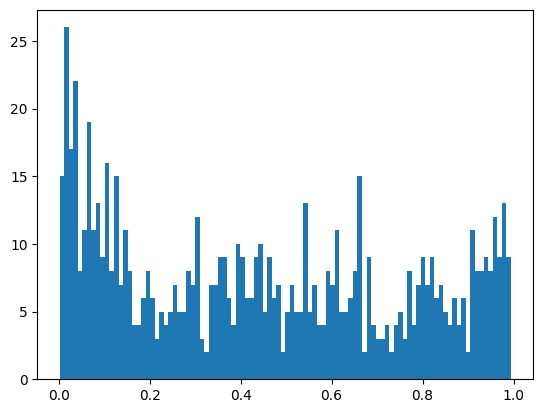

In [82]:
# print user_party histogram
import matplotlib.pyplot as plt
plt.hist(list(i for i in user_party.values() if i != 0 and i != 1), bins=100)

In [83]:
Cross_submissions = set()
Cross_comments = set()

for i in submission_pool:
    if graph_generator.data["submission"][i]._subreddit.name in xbox and user_party[graph_generator.data["submission"][i]._author.id] < 0.5:
        Cross_submissions.add(i)
    elif graph_generator.data["submission"][i]._subreddit.name in ps and user_party[graph_generator.data["submission"][i]._author.id] > 0.5:
        Cross_submissions.add(i)
        
for i in comment_pool:
    if graph_generator.data["comment"][i]._subreddit.name in xbox and user_party[graph_generator.data["comment"][i]._author.id] < 0.5:
        Cross_comments.add(i)
    elif graph_generator.data["comment"][i]._subreddit.name in ps and user_party[graph_generator.data["comment"][i]._author.id] > 0.5:
        Cross_comments.add(i)
        
print("The Number of Cross Submissions: {}".format(len(Cross_submissions)))
print("The Number of Cross Comments: {}".format(len(Cross_comments)))
print("The Ratio of Cross Submissions: {}".format(len(Cross_submissions) / len(submission_pool)))   
print("The Ratio of Cross Comments: {}".format(len(Cross_comments) / len(comment_pool)))

The Number of Cross Submissions: 175
The Number of Cross Comments: 14324
The Ratio of Cross Submissions: 0.08357211079274117
The Ratio of Cross Comments: 0.10399831558159628


In [84]:
Cross_submissions_xbox = set()
Cross_comments_xbox = set()

Cross_submissions_ps = set()
Cross_comments_ps = set()

for i in submission_pool:
    if graph_generator.data["submission"][i]._subreddit.name in xbox and user_party[graph_generator.data["submission"][i]._author.id] < 0.5:
        Cross_submissions_xbox.add(i)

    elif graph_generator.data["submission"][i]._subreddit.name in ps and user_party[graph_generator.data["submission"][i]._author.id] > 0.5:
        Cross_submissions_ps.add(i)
        
for i in comment_pool:
    if graph_generator.data["comment"][i]._subreddit.name in xbox and user_party[graph_generator.data["comment"][i]._author.id] < 0.5:
        Cross_comments_xbox.add(i)
    elif graph_generator.data["comment"][i]._subreddit.name in ps and user_party[graph_generator.data["comment"][i]._author.id] > 0.5:
        Cross_comments_ps.add(i)
        
print("The Number of submission from PS user to Xbox community: {}".format(len(Cross_submissions_xbox)))
print("The Number of submission from Xbox user to PS community: {}".format(len(Cross_submissions_ps)))
print("The Number of comment from PS user to Xbox community: {}".format(len(Cross_comments_xbox)))
print("The Number of comment from Xbox user to PS community: {}".format(len(Cross_comments_ps)))


The Number of submission from PS user to Xbox community: 157
The Number of submission from Xbox user to PS community: 18
The Number of comment from PS user to Xbox community: 7808
The Number of comment from Xbox user to PS community: 6516


In [85]:

Cross_comments_inner_party_xbox = set()
Cross_comments_inner_party_ps = set()
Cross_comments_counter_party_xbox = set()
Cross_comments_counter_party_ps = set()

Inner_comments_xbox = set()
Inner_comments_ps = set()

        
for i in comment_pool:
    try:
        if graph_generator.data["comment"][i]._subreddit.name in xbox and user_party[graph_generator.data["comment"][i]._author.id] < 0.5 and user_party[graph_generator.data["comment"][i]._parent._author.id] < 0.5:
            Cross_comments_inner_party_ps.add(i)
        elif graph_generator.data["comment"][i]._subreddit.name in ps and user_party[graph_generator.data["comment"][i]._author.id] > 0.5 and user_party[graph_generator.data["comment"][i]._parent._author.id] > 0.5:
            Cross_comments_inner_party_xbox.add(i)
        elif graph_generator.data["comment"][i]._subreddit.name in xbox and user_party[graph_generator.data["comment"][i]._author.id] < 0.5 and user_party[graph_generator.data["comment"][i]._parent._author.id] > 0.5:
            Cross_comments_counter_party_xbox.add(i)
        elif graph_generator.data["comment"][i]._subreddit.name in ps and user_party[graph_generator.data["comment"][i]._author.id] > 0.5 and user_party[graph_generator.data["comment"][i]._parent._author.id] < 0.5:
            Cross_comments_counter_party_ps.add(i)
        elif graph_generator.data["comment"][i]._subreddit.name in xbox and user_party[graph_generator.data["comment"][i]._author.id] > 0.5 and user_party[graph_generator.data["comment"][i]._parent._author.id] > 0.5:
            Inner_comments_xbox.add(i)
        elif graph_generator.data["comment"][i]._subreddit.name in ps and user_party[graph_generator.data["comment"][i]._author.id] < 0.5 and user_party[graph_generator.data["comment"][i]._parent._author.id] < 0.5:
            Inner_comments_ps.add(i)
    except:
        continue
        
print("The Number of conversation between PS user in Xbox community: {}".format(len(Cross_comments_inner_party_ps)))
print("The Number of conversation between Xbox user in PS community: {}".format(len(Cross_comments_inner_party_xbox)))
print("The Number of conversation between PS user in PS community: {}".format(len(Inner_comments_ps)))
print("The Number of conversation between Xbox user in Xbox community: {}".format(len(Inner_comments_xbox)))
print("The Number of conversation between PS user and Xbox user in Xbox community: {}".format(len(Cross_comments_counter_party_xbox)))
print("The Number of conversation between Xbox user and PS user in PS community: {}".format(len(Cross_comments_counter_party_ps)))
print("The Ratio of conversation between PS user in Xbox community in PS inner conversation: {}".format(len(Cross_comments_inner_party_ps) / (len(Inner_comments_ps) + len(Cross_comments_inner_party_ps))))
print("The Ratio of conversation between Xbox user in PS community in Xbox inner conversation: {}".format(len(Cross_comments_inner_party_xbox) / (len(Inner_comments_xbox) + len(Cross_comments_inner_party_xbox))))
print("The Ratio of inner-party activity of PS user in Xbox community in all activity of PS user in Xbox community: {}".format(len(Cross_comments_inner_party_ps) / (len(Cross_comments_inner_party_ps) + len(Cross_comments_counter_party_ps))))
print("The Ratio of inner-party activity of Xbox user in PS community in all activity of Xbox user in PS community: {}".format(len(Cross_comments_inner_party_xbox) / (len(Cross_comments_inner_party_xbox) + len(Cross_comments_counter_party_xbox))))


The Number of conversation between PS user in Xbox community: 884
The Number of conversation between Xbox user in PS community: 194
The Number of conversation between PS user in PS community: 40729
The Number of conversation between Xbox user in Xbox community: 16277
The Number of conversation between PS user and Xbox user in Xbox community: 3409
The Number of conversation between Xbox user and PS user in PS community: 3346
The Ratio of conversation between PS user in Xbox community in PS inner conversation: 0.021243361449547016
The Ratio of conversation between Xbox user in PS community in Xbox inner conversation: 0.011778276971647137
The Ratio of inner-party activity of PS user in Xbox community in all activity of PS user in Xbox community: 0.20898345153664302
The Ratio of inner-party activity of Xbox user in PS community in all activity of Xbox user in PS community: 0.05384401887316125


In [88]:
# pure user behavior (only xbox or only ps: 1 or 0)

pure_submissions_xbox = set()
pure_comments_xbox = set()

pure_comments_xbox_with_labeled_parent = set()
pure_comments_ps_with_labeled_parent = set()

pure_submissions_ps = set()
pure_comments_ps = set()

pure_counter_party_comments_xbox = set()
pure_counter_party_comments_ps = set()

pure_inner_comments_xbox = set()
pure_inner_comments_ps = set()

for i in submission_pool:
    if graph_generator.data["submission"][i]._subreddit.name in xbox and user_party[graph_generator.data["submission"][i]._author.id] == 1:
        pure_submissions_xbox.add(i)
    elif graph_generator.data["submission"][i]._subreddit.name in ps and user_party[graph_generator.data["submission"][i]._author.id] == 0:
        pure_submissions_ps.add(i)
        
        
for i in comment_pool:
    if graph_generator.data["comment"][i]._subreddit.name in xbox and user_party[graph_generator.data["comment"][i]._author.id] == 1:
        pure_comments_xbox.add(i)
    elif graph_generator.data["comment"][i]._subreddit.name in ps and user_party[graph_generator.data["comment"][i]._author.id] == 0:
        pure_comments_ps.add(i)
    
    try:
        if graph_generator.data["comment"][i]._subreddit.name in xbox and user_party[graph_generator.data["comment"][i]._author.id] == 1:
            pure_comments_xbox_with_labeled_parent.add(i)
        elif graph_generator.data["comment"][i]._subreddit.name in ps and user_party[graph_generator.data["comment"][i]._author.id] == 0:
            pure_comments_ps_with_labeled_parent.add(i)
        if graph_generator.data["comment"][i]._subreddit.name in xbox and user_party[graph_generator.data["comment"][i]._author.id] == 1 and user_party[graph_generator.data["comment"][i]._parent._author.id] < 0.5:
            pure_counter_party_comments_xbox.add(i)
        elif graph_generator.data["comment"][i]._subreddit.name in ps and user_party[graph_generator.data["comment"][i]._author.id] == 0 and user_party[graph_generator.data["comment"][i]._parent._author.id] >= 0.5:
            pure_counter_party_comments_ps.add(i)
            
        if graph_generator.data["comment"][i]._subreddit.name in xbox and user_party[graph_generator.data["comment"][i]._author.id] == 1 and user_party[graph_generator.data["comment"][i]._parent._author.id] == 1:
            pure_inner_comments_xbox.add(i)
            
        elif graph_generator.data["comment"][i]._subreddit.name in ps and user_party[graph_generator.data["comment"][i]._author.id] == 0 and user_party[graph_generator.data["comment"][i]._parent._author.id] == 0:
            pure_inner_comments_ps.add(i)
    except:
        continue
        

print("The Number of submission from user only use Xbox: {}".format(len(pure_submissions_xbox)))
print("The Number of submission from user only use PS: {}".format(len(pure_submissions_ps)))
print("The Number of comment from user only use Xbox: {}".format(len(pure_comments_xbox)))
print("The Number of comment from user only use PS: {}".format(len(pure_comments_ps)))
print("The Number of conversation between only Xbox user and PS user in Xbox community: {}".format(len(pure_counter_party_comments_xbox)))
print("The Number of conversation between only PS user and Xbox user in PS community: {}".format(len(pure_counter_party_comments_ps)))
print("The Number of conversation between only Xbox user in Xbox community: {}".format(len(pure_inner_comments_xbox)))
print("The Number of conversation between only PS user in PS community: {}".format(len(pure_inner_comments_ps)))
print("The Ratio of conversation between only Xbox user and PS user in Xbox community in all conversation of Xbox community with only Xbox user: {}".format(len(pure_counter_party_comments_xbox) / len(pure_comments_xbox_with_labeled_parent)))
print("The Ratio of conversation between only PS user and Xbox user in PS community in all conversation of PS community with only PS user: {}".format(len(pure_counter_party_comments_ps) / len(pure_comments_ps_with_labeled_parent)))
print("The Ratio of conversation between only Xbox user in Xbox community in all conversation of Xbox community with only Xbox user: {}".format(len(pure_inner_comments_xbox) / len(pure_comments_xbox_with_labeled_parent)))
print("The Ratio of conversation between only PS user in PS community in all conversation of PS community with only PS user: {}".format(len(pure_inner_comments_ps) / len(pure_comments_ps_with_labeled_parent)))




        


The Number of submission from user only use Xbox: 598
The Number of submission from user only use PS: 701
The Number of comment from user only use Xbox: 17367
The Number of comment from user only use PS: 54196
The Number of conversation between only Xbox user and PS user in Xbox community: 1579
The Number of conversation between only PS user and Xbox user in PS community: 1509
The Number of conversation between only Xbox user in Xbox community: 4118
The Number of conversation between only PS user in PS community: 16137
The Ratio of conversation between only Xbox user and PS user in Xbox community in all conversation of Xbox community with only Xbox user: 0.09091956008521909
The Ratio of conversation between only PS user and Xbox user in PS community in all conversation of PS community with only PS user: 0.02784338327551849
The Ratio of conversation between only Xbox user in Xbox community in all conversation of Xbox community with only Xbox user: 0.23711637012725284
The Ratio of conver

In [ ]:
user_ids = list(graph_generator.used_redditors)
single_party = []
counter_party = []
ps = {'PS5'}
xbox = {'XboxSeriesX', 'XboxSeriesS'}

for i in range()
    

In [38]:
subreddit_names = [subreddit._data["name"] for subreddit in subreddits]
print(subreddit_names)

['PS5', 'XboxSeriesX', 'XboxSeriesS', 'PS5', 'XboxSeriesX', 'XboxSeriesS']


# optional: GCN with party label

In [24]:
# GCN model
import torch
import torch.nn as nn
import torch.nn.functional as F


def graph_convolution(adj, x, w):
    """
    A: adjacency matrix
    X: feature matrix
    W: weight matrix
    """
    # A: (N, N), X: (N, F), W: (F, F')
    # (N, F) * (F, F') = (N, F')
    # (N, N) * (N, F') = (N, F')
    # (N, F') * (F', F) = (N, F)
    return torch.matmul(torch.matmul(adj, x), w)


class GCNLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        F: input feature dimension
        F_: output feature dimension
        """
        super(GCNLayer, self).__init__()
        self.F = input_dim
        self.F_ = output_dim
        self.W = nn.Parameter(torch.FloatTensor(self.F, self.F_))

        nn.init.xavier_uniform_(self.W)

    def forward(self, adj, x):
        return graph_convolution(adj, x, self.W)


class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        """
        A: adjacency matrix
        X: feature matrix
        F: input feature dimension
        F_: output feature dimension
        n_layers: number of GCN layers
        """
        super(GCN, self).__init__()
        self.F = input_dim
        self.F_ = hidden_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.layers = nn.ModuleList()
        for i in range(n_layers):
            self.layers.append(GCNLayer(input_dim, hidden_dim))
            input_dim = hidden_dim
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.drop_out = nn.Dropout(0.5)

    def forward(self, adj, x):
        for i in range(self.n_layers):
            x = self.layers[i](adj, x)
            # add relu and dropout
            # x = F.relu(x)
            # x = self.drop_out(x)
            
        x = self.output_layer(x)
        x = F.softmax(x, dim=1)
        return x

class GCNWithParty(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        """
        input_dim: input feature dimension
        hidden_dim: hidden feature dimension, which should be even. If not, it will be changed to hidden_dim - 1
        output_dim: output feature dimension
        n_layers: number of GCN layers
        """
        super(GCNWithParty, self).__init__()
        self.F = input_dim
        self.F_ = hidden_dim // 2
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.layers_inner = nn.ModuleList()
        for _ in range(n_layers):
            self.layers_inner.append(GCNLayer(input_dim, self.F_))
            input_dim = self.F_ * 2
        self.layers_outer = nn.ModuleList()
        for _ in range(n_layers):
            self.layers_outer.append(GCNLayer(input_dim, self.F_))
            input_dim = self.F_ * 2
        self.output_layer = nn.Linear(self.F_ * 2, output_dim)
        self.drop_out = nn.Dropout(0.5)

    def forward(self, x, adj_inner, adj_outer):
        for i in range(self.n_layers):
            x_inner = self.layers_inner[i](adj_inner, x)
            x_outer = self.layers_outer[i](adj_outer, x)
            # concat inner and outer
            x = torch.cat([x_inner, x_outer], dim=1)
            # add relu and dropout
            # x = F.relu(x)
            # x = self.drop_out(x)
            
        x = self.output_layer(x) 
        x = F.softmax(x, dim=1)
        return x
    

In [27]:
from typing import Dict, List, Tuple
from utils import sp2torch_single
import scipy.sparse as sp


def get_inner_and_outer_adjacency_matrix_user_embedding_with_batch(time_tuple_used, graph_generator, user_features, train_size, label_size, party_label_used):
    def construct_train_size_graph(time_tuple_used, graph_generator, time_tuple, train_size, label_size):
        graph_constructor_args = {
            "time_tuples": [],
            "n_args": {},
        }
        for idx in range(len(time_tuple_used) - train_size - label_size + 1):
            user_ids_used = set()
            for time_tuple in time_tuple_used[idx:idx + train_size]:
                user_ids_used |= graph_generator.graphs_info[time_tuple][
                    graph_generator.graph_type].used_redditors


            kargs = {
                "used_redditors": user_ids_used,
                "considered_redditors": user_ids_used,
                "time_tuple": (time_tuple_used[idx][0],
                               time_tuple_used[idx + train_size - 1][1]),
            }
            graph_constructor_args["time_tuples"].append(
                kargs["time_tuple"])
            graph_constructor_args["n_args"][kargs["time_tuple"]] = kargs
        graphs, graphs_info = graph_generator.construct_graph_outer(
            **graph_constructor_args)
        return graphs, graphs_info
    
    def seperate_adjacency_matrix(adjacency_matrix, user_ids_used, party_label):
        import math
        adjacency_matrix = adjacency_matrix.tocoo()
        col = adjacency_matrix.col
        row = adjacency_matrix.row
        data = adjacency_matrix.data
        col_inner = []
        row_inner = []
        data_inner = []
        col_outer = []
        row_outer = []
        data_outer = []
        for i, (row_idx, col_idx, value) in enumerate(zip(row, col, data)):
            if math.ceil(party_label[user_ids_used[row_idx]]) == math.ceil(party_label[user_ids_used[col_idx]]):
                col_inner.append(col_idx)
                row_inner.append(row_idx)
                data_inner.append(value)
            else:
                col_outer.append(col_idx)
                row_outer.append(row_idx)
                data_outer.append(value)
        adjacency_matrix_inner = sp.coo_matrix((data_inner, (row_inner, col_inner)), shape=adjacency_matrix.shape)
        adjacency_matrix_outer = sp.coo_matrix((data_outer, (row_outer, col_outer)), shape=adjacency_matrix.shape)
        return adjacency_matrix_inner, adjacency_matrix_outer
    
    graphs_created, graphs_info_created = construct_train_size_graph(time_tuple_used, graph_generator, time_tuple_used, train_size, label_size)
    output_tensors = []
    for item in range(len(time_tuple_used) - train_size - label_size + 1):
        time_tuple_temp = time_tuple_used[item]        

        user_ids_used_dict = graphs_info_created[item].used_redditors_index
        idx2user_id = {idx: user_id for user_id, idx in
                       user_ids_used_dict.items()}
        user_ids_used = set(idx2user_id.values())
        user_ids_used_list = [idx2user_id[idx] for idx in
                              range(len(idx2user_id))]
        
        graph = graphs_created[item]
        
        graph_inner, graph_outer = seperate_adjacency_matrix(graph, user_ids_used_list, party_label_used)
        
        graph_inner = sp2torch_single(graph_inner).float()
        graph_outer = sp2torch_single(graph_outer).float()
        
        labels = []
        for user_id in user_ids_used_list:
            for i in range(label_size):
                graph_info = graph_generator.graphs_info[time_tuple_used[item + train_size + i]][graph_generator.graph_type]
                if user_id in graph_info.considered_redditors:
                    labels.append(1)
                    break
            else:
                labels.append(0)
        labels = torch.tensor(labels).long()
        
        # collect user features from dataframe (user_features)
        # when user_id and time_end_time_stamp match
        # it should finally be a numpy array before converting to torch tensor
        # so it should follow the order of user_ids_used_list
        user_features_used = []
        for user_id in user_ids_used_list:
            if time_tuple_used[item + train_size - 1][1] not in user_features[(user_features["user_id"] == user_id)]["time_end_time_stamp"].values:
                print(user_id)
                print(user_features[(user_features["user_id"] == user_id)]["time_end_time_stamp"].values)
                print(time_tuple_used[item + train_size - 1][1])
                print("error")
                raise
            user_feature = user_features[(user_features["user_id"] == user_id) & (user_features["time_end_time_stamp"] == time_tuple_used[item + train_size - 1][1])].values
            user_features_used.append(user_feature)
        user_features_used = np.concatenate(user_features_used, axis=0)
        user_features_used = torch.tensor(user_features_used).float()
        
        output_tensors.append((user_features_used, graph_inner, graph_outer, labels))
    return output_tensors        
    

In [28]:
train_features_used = train_user_feature_dataset_total[features_importance]
valid_features_used = valid_user_feature_dataset_total[features_importance]
test_features_used = test_user_feature_dataset_total[features_importance]

test_datasets = get_inner_and_outer_adjacency_matrix_user_embedding_with_batch(test_time_tuple, graph_generator, test_features_used, train_size, label_size, user_party)
train_datasets = get_inner_and_outer_adjacency_matrix_user_embedding_with_batch(train_time_tuple, graph_generator, train_features_used, train_size, label_size, user_party)
valid_datasets = get_inner_and_outer_adjacency_matrix_user_embedding_with_batch(valid_time_tuple, graph_generator, valid_features_used, train_size, label_size, user_party)

Constructing graph:   0%|          | 0/3 [00:00<?, ?it/s]

Constructing graph: 100%|██████████| 3/3 [00:05<00:00,  1.76s/it]
/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()
Constructing graph: 100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


In [31]:
import time
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report


# model = GCN(input_dim=30, hidden_dim=15, output_dim=2, n_layers=1)
model = GCNWithParty(input_dim=30, hidden_dim=30, output_dim=2, n_layers=1)
model = model.cuda()    
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.CrossEntropyLoss()

minimum_loss = 100000000
early_stop = 0
early_stop_threshold = 10
epochs = 300
max_features = np.max(train_user_feature_dataset_total[features_importance].values, axis=0)
max_features = torch.tensor(max_features).float().cuda()
for epoch in range(epochs):
    begin_time = time.time()
    
    for batch_idx, (features, adj_inner, adj_outer, labels) in enumerate(train_datasets):
        adj_inner = adj_inner.cuda()
        adj_outer = adj_outer.cuda()
        features = features.cuda()
        features = features / max_features
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(features, adj_inner, adj_outer)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print("train_loss: {}".format(loss.item()))
        if torch.isnan(loss).any():
            print("nan in loss")
            print(loss)
            break
        if torch.isnan(outputs).any():
            print("nan in outputs")
            print(outputs)
            break
    
    model.eval()
    with torch.no_grad():
        total_loss = 0
        total_output = []
        total_label = []
        for batch_idx, (features, adj_inner, adj_outer, labels) in enumerate(valid_datasets):
            adj_inner = adj_inner.cuda()
            adj_outer = adj_outer.cuda()
            features = features.cuda()
            features = features / max_features
            labels = labels.cuda()
            outputs = model(features, adj_inner, adj_outer)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * len(labels)
            # print("valid_loss: {}".format(loss.item()))
            total_output.append(outputs.detach().cpu().numpy()[:, 1])
            total_label.append(labels.detach().cpu().numpy())
            
        total_output = np.concatenate(total_output, axis=0)
        total_label = np.concatenate(total_label, axis=0)
        total_loss /= len(total_label)
        # print("Vaildation Result in epoch {}".format(epoch))
        print(classification_report(total_label, total_output > 0.5))
        # detect whether there is nan in test_output
        if np.isnan(total_output).any():
            print("nan in valid_output")
            print(total_output)
            break
        print("ROC AUC: %f" % (roc_auc_score(total_label, total_output)))
        print("Average precision: %f" % (average_precision_score(total_label, total_output)))
            
        print("Epoch: {}, Time: {}, Valid Loss: {}".format(epoch, time.time() - begin_time, total_loss))
            
            
        if total_loss < minimum_loss:
            minimum_loss = total_loss
            early_stop = 0
            
            test_loss = 0
            test_output = []
            test_label = []
            for batch_idx, (features, adj_inner, adj_outer, labels) in enumerate(test_datasets):
                adj_inner = adj_inner.cuda()
                adj_outer = adj_outer.cuda()
                features = features.cuda()
                features = features / max_features
                labels = labels.cuda()
                outputs = model(features, adj_inner, adj_outer)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * len(labels)
                print("test_loss: {}".format(loss.item()))
                test_output.append(outputs.detach().cpu().numpy()[:, 1])
                test_label.append(labels.detach().cpu().numpy())
                
            test_output = np.concatenate(test_output, axis=0)
            test_label = np.concatenate(test_label, axis=0)
            test_loss /= len(test_label)
            print("Test Result in epoch {}".format(epoch))
            print(classification_report(test_label, test_output > 0.5))
            
            print("ROC AUC: %f" % (roc_auc_score(test_label, test_output)))
            print("Average precision: %f" % (average_precision_score(test_label, test_output)))
            
            print("Epoch: {}, Time: {}, Test Loss: {}".format(epoch, time.time() - begin_time, test_loss))
        else:
            early_stop += 1
            

        if early_stop >= early_stop_threshold:
            break

/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user2/.conda/envs/reddittrain/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

              precision    recall  f1-score   support

           0       0.54      1.00      0.70      2513
           1       0.00      0.00      0.00      2108

    accuracy                           0.54      4621
   macro avg       0.27      0.50      0.35      4621
weighted avg       0.30      0.54      0.38      4621

ROC AUC: 0.371970
Average precision: 0.374370
Epoch: 0, Time: 0.0929865837097168, Valid Loss: 0.6995059209219745
test_loss: 0.6892895698547363
test_loss: 0.6741462349891663
test_loss: 0.6718825697898865
Test Result in epoch 0
              precision    recall  f1-score   support

           0       0.69      1.00      0.82      3128
           1       0.00      0.00      0.00      1382

    accuracy                           0.69      4510
   macro avg       0.35      0.50      0.41      4510
weighted avg       0.48      0.69      0.57      4510

ROC AUC: 0.363357
Average precision: 0.236292
Epoch: 0, Time: 0.11627554893493652, Test Loss: 0.6785064741275263
       

# GAT

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


dv = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class GraphAttentionLayer(nn.Module):
    """
    Simple GAT layer, similar to https://arxiv.org/abs/1710.10903
    """

    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GraphAttentionLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.empty(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.empty(size=(2 * out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, h, adj):
        Wh = torch.mm(h, self.W)  # h.shape: (N, in_features), Wh.shape: (N, out_features)
        e = self._prepare_attentional_mechanism_input(Wh)

        zero_vec = -9e15 * torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime = torch.matmul(attention, Wh)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

    def _prepare_attentional_mechanism_input(self, Wh):
        # Wh.shape (N, out_feature)
        # self.a.shape (2 * out_feature, 1)
        # Wh1&2.shape (N, 1)
        # e.shape (N, N)
        Wh1 = torch.matmul(Wh, self.a[:self.out_features, :])
        Wh2 = torch.matmul(Wh, self.a[self.out_features:, :])
        # broadcast add
        e = Wh1 + Wh2.T
        return self.leakyrelu(e)

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'


class SpecialSpmmFunction(torch.autograd.Function):
    """Special function for only sparse region backpropataion layer."""

    @staticmethod
    def forward(ctx, indices, values, shape, b):
        assert indices.requires_grad == False
        a = torch.sparse_coo_tensor(indices, values, shape)
        ctx.save_for_backward(a, b)
        ctx.N = shape[0]
        return torch.matmul(a, b)

    @staticmethod
    def backward(ctx, grad_output):
        a, b = ctx.saved_tensors
        grad_values = grad_b = None
        if ctx.needs_input_grad[1]:
            grad_a_dense = grad_output.matmul(b.t())
            edge_idx = a._indices()[0, :] * ctx.N + a._indices()[1, :]
            grad_values = grad_a_dense.view(-1)[edge_idx]
        if ctx.needs_input_grad[3]:
            grad_b = a.t().matmul(grad_output)
        return None, grad_values, None, grad_b


class SpecialSpmm(nn.Module):
    def forward(self, indices, values, shape, b):
        return SpecialSpmmFunction.apply(indices, values, shape, b)


class SpGraphAttentionLayer(nn.Module):
    """
    Sparse version GAT layer, similar to https://arxiv.org/abs/1710.10903
    """

    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(SpGraphAttentionLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_normal_(self.W.data, gain=1.414)

        self.a = nn.Parameter(torch.zeros(size=(1, 2 * out_features)))
        nn.init.xavier_normal_(self.a.data, gain=1.414)

        self.dropout = nn.Dropout(dropout)
        self.leakyrelu = nn.LeakyReLU(self.alpha)
        self.special_spmm = SpecialSpmm()

    def forward(self, input, adj):
        # dv = 'cuda' if input.is_cuda else 'cpu'

        N = input.size()[0]
        edge = adj.nonzero().t()

        h = torch.mm(input, self.W)
        # h: N x out
        # assert not torch.isnan(h).any()

        # Self-attention on the nodes - Shared attention mechanism
        edge_h = torch.cat((h[edge[0, :], :], h[edge[1, :], :]), dim=1).t()
        # edge: 2*D x E

        edge_e = torch.exp(-self.leakyrelu(self.a.mm(edge_h).squeeze()))
        # assert not torch.isnan(edge_e).any()
        # edge_e: E

        e_rowsum = self.special_spmm(edge, edge_e, torch.Size([N, N]), torch.ones(size=(N, 1), device=dv))
        # e_rowsum: N x 1

        edge_e = self.dropout(edge_e)
        # edge_e: E

        h_prime = self.special_spmm(edge, edge_e, torch.Size([N, N]), h)
        # assert not torch.isnan(h_prime).any()
        # h_prime: N x out

        h_prime = h_prime.div(e_rowsum)
        # h_prime: N x out
        # assert not torch.isnan(h_prime).any()

        if self.concat:
            # if this layer is not last layer,
            return F.elu(h_prime)
        else:
            # if this layer is last layer,
            return h_prime

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'


class GAT(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, alpha, nheads):
        """Dense version of GAT."""
        super(GAT, self).__init__()
        self.dropout = dropout

        self.attentions = [GraphAttentionLayer(nfeat, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in
                           range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_att = GraphAttentionLayer(nhid * nheads, nclass, dropout=dropout, alpha=alpha, concat=False)

    def forward(self, x, adj):
        x = F.dropout(x, self.dropout, training=self.training)
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_att(x, adj))
        return F.log_softmax(x, dim=1)


class SpGAT(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, alpha, nheads):
        """Sparse version of GAT."""
        super(SpGAT, self).__init__()
        self.dropout = dropout

        self.attentions = [SpGraphAttentionLayer(nfeat,
                                                 nhid,
                                                 dropout=dropout,
                                                 alpha=alpha,
                                                 concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_att = SpGraphAttentionLayer(nhid * nheads,
                                             nclass,
                                             dropout=dropout,
                                             alpha=alpha,
                                             concat=False)

    def forward(self, adj, x):
        x = F.dropout(x, self.dropout, training=self.training)
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_att(x, adj))
        return F.log_softmax(x, dim=1)


In [24]:
from typing import Dict, List, Tuple
from utils import sp2torch_single


def get_adjacency_matrix_user_embedding_with_batch(time_tuple_used, graph_generator, user_features, train_size, label_size):
    def construct_train_size_graph(time_tuple_used, graph_generator, time_tuple, train_size, label_size):
        graph_constructor_args = {
            "time_tuples": [],
            "n_args": {},
        }
        for idx in range(len(time_tuple_used) - train_size - label_size + 1):
            user_ids_used = set()
            for time_tuple in time_tuple_used[idx:idx + train_size]:
                user_ids_used |= graph_generator.graphs_info[time_tuple][
                    graph_generator.graph_type].used_redditors


            kargs = {
                "used_redditors": user_ids_used,
                "considered_redditors": user_ids_used,
                "time_tuple": (time_tuple_used[idx][0],
                               time_tuple_used[idx + train_size - 1][1]),
            }
            graph_constructor_args["time_tuples"].append(
                kargs["time_tuple"])
            graph_constructor_args["n_args"][kargs["time_tuple"]] = kargs
        graphs, graphs_info = graph_generator.construct_graph_outer(
            **graph_constructor_args)
        return graphs, graphs_info
    
    graphs_created, graphs_info_created = construct_train_size_graph(time_tuple_used, graph_generator, time_tuple_used, train_size, label_size)
    output_tensors = []
    for item in range(len(time_tuple_used) - train_size - label_size + 1):
        time_tuple_temp = time_tuple_used[item]        

        user_ids_used_dict = graphs_info_created[item].used_redditors_index
        idx2user_id = {idx: user_id for user_id, idx in
                       user_ids_used_dict.items()}
        user_ids_used = set(idx2user_id.values())
        user_ids_used_list = [idx2user_id[idx] for idx in
                              range(len(idx2user_id))]
        
        graph = graphs_created[item]
        print(graph.nnz)
        graph = sp2torch_single(graph).float()
        
        labels = []
        for user_id in user_ids_used_list:
            for i in range(label_size):
                graph_info = graph_generator.graphs_info[time_tuple_used[item + train_size + i]][graph_generator.graph_type]
                if user_id in graph_info.considered_redditors:
                    labels.append(1)
                    break
            else:
                labels.append(0)
        labels = torch.tensor(labels).long()
        
        # collect user features from dataframe (user_features)
        # when user_id and time_end_time_stamp match
        # it should finally be a numpy array before converting to torch tensor
        # so it should follow the order of user_ids_used_list
        user_features_used = []
        for user_id in user_ids_used_list:
            if time_tuple_used[item + train_size - 1][1] not in user_features[(user_features["user_id"] == user_id)]["time_end_time_stamp"].values:
                print(user_id)
                print(user_features[(user_features["user_id"] == user_id)]["time_end_time_stamp"].values)
                print(time_tuple_used[item + train_size - 1][1])
                print("error")
                raise
            user_feature = user_features[(user_features["user_id"] == user_id) & (user_features["time_end_time_stamp"] == time_tuple_used[item + train_size - 1][1])].values
            user_features_used.append(user_feature)
        user_features_used = np.concatenate(user_features_used, axis=0)
        user_features_used = torch.tensor(user_features_used).float()
        
        output_tensors.append((graph, user_features_used, labels))
    return output_tensors        
    
    
    

In [23]:
# testing GCN for these 30 features
# features_importance = model.get_score()
# features_importance = sorted(features_importance.items(), key=lambda x: x[1], reverse=True)

# features_importance = [feature[0] for feature in features_importance]
# features_importance = features_importance[:30]

train_features_used = train_user_feature_dataset_total[features_importance]
valid_features_used = valid_user_feature_dataset_total[features_importance]
test_features_used = test_user_feature_dataset_total[features_importance]

test_datasets = get_adjacency_matrix_user_embedding_with_batch(test_time_tuple, graph_generator, test_features_used, train_size, label_size)
train_datasets = get_adjacency_matrix_user_embedding_with_batch(train_time_tuple, graph_generator, train_features_used, train_size, label_size)
valid_datasets = get_adjacency_matrix_user_embedding_with_batch(valid_time_tuple, graph_generator, valid_features_used, train_size, label_size)



Constructing graph:   0%|          | 0/3 [00:00<?, ?it/s]

Constructing graph: 100%|██████████| 3/3 [00:21<00:00,  7.07s/it]
/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


9912
10077
9668


Constructing graph: 100%|██████████| 27/27 [00:51<00:00,  1.92s/it]


7092
7602
7795
7936
7932
7357
6871
6622
6390
6347
8369
11952
14174
16004
16305
16489
17228
15878
13055
11619
10272
10163
10071
9457
11782
12238
12960


Constructing graph: 100%|██████████| 3/3 [00:05<00:00,  1.95s/it]


10084
10234
11075


In [2]:
# set CUDA_LAUNCH_BLOCKING=1.
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
model = SpGAT(30, 30, 1, 0.6, 0.2, 1)
model = model.to(torch.device('cuda'))

In [30]:
import time
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report


model = SpGAT(30, 30, 1, 0.6, 0.2, 1)
model = model.to(torch.device('cuda'))
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.CrossEntropyLoss()

minimum_loss = 100000000
early_stop = 0
early_stop_threshold = 10
epochs = 300
max_features = np.max(train_user_feature_dataset_total[features_importance].values, axis=0)
max_features = torch.tensor(max_features).float().cuda()
for epoch in range(epochs):
    begin_time = time.time()
    
    for batch_idx, (adj, features, labels) in enumerate(train_datasets):
        adj = adj.to_dense().cuda()
        features = features.cuda()
        features = features / max_features
        labels = labels.cuda()
        # detect whether there is nan in adj by torch function
        if torch.isnan(adj).any():
            print("nan in adj")
            print(adj)
            break
        # detect whether there is nan in features
        if np.isnan(features.detach().cpu().numpy()).any():
            print("nan in features")
            print(features)
            break
        # detect whether there is nan in labels
        if np.isnan(labels.detach().cpu().numpy()).any():
            print("nan in labels")
            print(labels)
            break
        optimizer.zero_grad()
        outputs = model(adj, features)
        print(outputs.device, labels.device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print("train_loss: {}".format(loss.item()))
        if torch.isnan(loss).any():
            print("nan in loss")
            print(loss)
            break
        if torch.isnan(outputs).any():
            print("nan in outputs")
            print(outputs)
            break
    
    model.eval()
    with torch.no_grad():
        total_loss = 0
        total_output = []
        total_label = []
        for batch_idx, (adj, features, labels) in enumerate(valid_datasets):
            adj = adj.cuda()
            features = features.cuda()
            features = features / max_features
            labels = labels.cuda()
            outputs = model(adj, features)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * len(labels)
            # print("valid_loss: {}".format(loss.item()))
            total_output.append(outputs.detach().cpu().numpy()[:, 1])
            total_label.append(labels.detach().cpu().numpy())
            
        total_output = np.concatenate(total_output, axis=0)
        total_label = np.concatenate(total_label, axis=0)
        total_loss /= len(total_label)
        print("Vaildation Result in epoch {}".format(epoch))
        print(classification_report(total_label, total_output > 0.5))
        # detect whether there is nan in test_output
        if np.isnan(total_output).any():
            print("nan in valid_output")
            print(total_output)
            break
        print("ROC AUC: %f" % (roc_auc_score(total_label, total_output)))
        print("Average precision: %f" % (average_precision_score(total_label, total_output)))
            
        print("Epoch: {}, Time: {}, Valid Loss: {}".format(epoch, time.time() - begin_time, total_loss))
            
            
        if total_loss < minimum_loss:
            minimum_loss = total_loss
            early_stop = 0
            
            test_loss = 0
            test_output = []
            test_label = []
            for batch_idx, (adj, features, labels) in enumerate(test_datasets):
                adj = adj.cuda()
                features = features.cuda()
                features = features / max_features
                labels = labels.cuda()
                outputs = model(adj, features)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * len(labels)
                # print("test_loss: {}".format(loss.item()))
                test_output.append(outputs.detach().cpu().numpy()[:, 1])
                test_label.append(labels.detach().cpu().numpy())
                
            test_output = np.concatenate(test_output, axis=0)
            test_label = np.concatenate(test_label, axis=0)
            test_loss /= len(test_label)
            print("Test Result in epoch {}".format(epoch))
            print(classification_report(test_label, test_output > 0.5))
            
            print("ROC AUC: %f" % (roc_auc_score(test_label, test_output)))
            print("Average precision: %f" % (average_precision_score(test_label, test_output)))
            
            print("Epoch: {}, Time: {}, Test Loss: {}".format(epoch, time.time() - begin_time, test_loss))
        else:
            early_stop += 1
            

        if early_stop >= early_stop_threshold:
            break

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Just something for test

In [108]:
train_features_used = train_user_feature_dataset_total[features_importance]
train_datasets_2 = get_adjacency_matrix_user_embedding_with_batch(train_time_tuple, graph_generator, train_features_used, train_size, label_size)
# test_datasets_2 = get_adjacency_matrix_user_embedding_with_batch_optim(test_time_tuple, graph_generator, test_features_used, train_size, label_size)


Constructing graph:   0%|          | 0/27 [00:00<?, ?it/s]

Constructing graph: 100%|██████████| 27/27 [00:49<00:00,  1.84s/it]
/home/user2/maiqi/Reddit/XGB/utils.py:26: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


7092
7602
7795
7936
7932
7357
6871
6622
6390
6347
8369
11952
14174
16004
16305
16489
17228
15878
13055
11619
10272
10163
10071
9457
11782
12238
12960


In [113]:
train_datasets_2[0][2]


tensor([1, 1, 0,  ..., 0, 0, 1])

In [114]:
train_datasets[0][2]

tensor([1, 1, 0,  ..., 0, 0, 1])

In [95]:
test_datasets_2[0][0]

tensor(indices=tensor([[ 328,  591,  719,  ...,  819, 1420, 1514],
                       [   1,    1,    1,  ..., 1519, 1519, 1519]]),
       values=tensor([0.1091, 0.1140, 0.2182,  ..., 0.0373, 0.1741, 0.2582]),
       size=(1521, 1521), nnz=9912, layout=torch.sparse_coo)

In [102]:
test_datasets[0][2][0]

tensor(0)

In [103]:
test_datasets_2[0][2][0]

tensor(0)

In [57]:
subreddits[2].comments_id

[]

In [26]:
import praw
import json
client_id = "tSOSh-KX-S59nU7ULgXmSA"
client_secret = "uZik5-GaNyGEIc5_6C9JwE338vbnvg"
user_agent = "TempVersion:0.1"
username = "maiqjiang2"
password = json.load(open("../masked.json", "r"))

reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent,
    username=username,
    password=password
)

In [47]:
a = list(reddit.info(['t5_XboxSeriesX']))[0]

/tmp/ipykernel_1960144/1018794825.py:1: DeprecationWarning: Positional arguments for 'Reddit.info' will no longer be supported in PRAW 8.
Call this function with 'fullnames' as a keyword argument.
  a = list(reddit.info(['t5_XboxSeriesX']))[0]


IndexError: list index out of range